In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv
/kaggle/input/qa-intents-dataset-university-domain/labels_description.txt
/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv


In [2]:
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
train_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [3]:
full_data = pd.concat([train_data, test_data])
full_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14113 entries, 0 to 882
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14113 non-null  object
 1   intent  14113 non-null  object
dtypes: object(2)
memory usage: 330.8+ KB


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_data, test_size=0.2, random_state=42)

In [6]:
unique_values_normalized = train['intent'].value_counts(normalize=True)
print(unique_values_normalized*100)

intent
sched_teacher                8.582817
sched_for_group              3.126661
sched_for_group_day          3.046944
wifi                         2.143490
status_free                  2.037201
                               ...   
location_general             0.168291
loc_nsu_cafeteria            0.168291
student_trade_union_enter    0.159433
loc_passport_office          0.159433
staff_trade_union_enter      0.159433
Name: proportion, Length: 142, dtype: float64


In [7]:
unique_values_normalized2 = test['intent'].value_counts(normalize=True)
print(unique_values_normalized2*100)

intent
sched_teacher              7.616011
sched_for_group_day        3.010981
sched_for_group            2.833865
wifi                       2.267092
status_free                2.054552
                             ...   
volunteer_become           0.106270
staff_trade_union_enter    0.106270
cvvr_define                0.106270
nsu_foundation_date        0.070847
location_general           0.070847
Name: proportion, Length: 142, dtype: float64


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2823 entries, 8079 to 8188
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2823 non-null   object
 1   intent  2823 non-null   object
dtypes: object(2)
memory usage: 66.2+ KB


In [9]:
from transformers import BertTokenizer

In [10]:
# Создание токенизатора BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# Преобразование текста в токены
input_texts = train['text'].values.tolist()  # Преобразуйте тексты в список
input_ids = tokenizer.batch_encode_plus(input_texts, add_special_tokens=True, padding=True, truncation=True, max_length=64, return_tensors='pt')['input_ids']
# labels = torch.tensor(train_data['intent'].values)

In [12]:
# Преобразование меток в числовой формат
unique_intents = train['intent'].unique().tolist()
intent_mapping = {intent: i for i, intent in enumerate(unique_intents)}
train_labels = [intent_mapping[intent] for intent in train['intent']]
test_labels = [intent_mapping[intent] for intent in test['intent']]

In [13]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, AdamW

In [14]:
# Загрузка предобученной модели BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_data['intent'].unique()))

# Определение оптимизатора
optimizer = AdamW(model.parameters(), lr=1e-3)

# # Преобразование текста в токены и создание маски внимания
# input_ids = tokenizer.encode(train_data['text'].values, add_special_tokens=True, padding=True, truncation=True, max_length=64, return_tensors='pt')
# #labels = torch.tensor(train_data['intent'].values)

# Преобразование текста в токены и создание маски внимания
encoding = tokenizer.batch_encode_plus(
    train['text'].values.tolist(),  # Преобразуйте тексты в список
    add_special_tokens=True,
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors='pt'
)
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
import matplotlib.pyplot as plt

def plot_loss(loss_values):
    plt.plot(loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

In [16]:
from torch.utils.data import Dataset, DataLoader

class IntentClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Создание DataLoader
def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = IntentClassificationDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

# Использование DataLoader в вашем коде
batch_size = 8 # 16
max_len = 64
train_data_loader = create_data_loader(train['text'].values.tolist(), train_labels, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(test['text'].values.tolist(), test_labels, tokenizer, max_len, batch_size)

In [17]:
print(next(iter(train_data_loader)))

{'text': ['математический находится', 'расписание для Кудинов О.В.', 'какой там график военного стола универа плиз', 'находится корпус административный', 'аптечка отыскать', 'где расположен где поликлиника', 'можно ли заплатить онлайн за проживание пожалуйста', 'деканат института философии и права находится'], 'input_ids': tensor([[  101,  1191, 10260, 22919, 15290, 29745, 10260, 22919, 10325, 29752,
         15290, 29747, 23925, 15414,  1192, 10260, 29750, 14150, 29742, 10325,
         22919, 29747, 17432,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  1195, 10260, 29747, 29746, 10325, 29747, 28995, 10325, 15290,
          1184, 29436, 17432,  1189, 29748, 29742, 10325, 18947, 19259,  1193,
     

In [18]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score

Epoch 1: 100%|██████████| 1412/1412 [1:05:37<00:00,  2.79s/it]


Epoch: 1, Train Loss: 4.6928


Validation Epoch 1:   0%|          | 1/353 [00:00<04:17,  1.37it/s]

(8, 142)


Validation Epoch 1:   1%|          | 2/353 [00:01<04:28,  1.31it/s]

(8, 142)


Validation Epoch 1:   1%|          | 3/353 [00:02<04:22,  1.33it/s]

(8, 142)


Validation Epoch 1:   1%|          | 4/353 [00:02<04:18,  1.35it/s]

(8, 142)


Validation Epoch 1:   1%|▏         | 5/353 [00:03<04:21,  1.33it/s]

(8, 142)


Validation Epoch 1:   2%|▏         | 6/353 [00:04<04:19,  1.34it/s]

(8, 142)


Validation Epoch 1:   2%|▏         | 7/353 [00:05<04:17,  1.35it/s]

(8, 142)


Validation Epoch 1:   2%|▏         | 8/353 [00:05<04:15,  1.35it/s]

(8, 142)


Validation Epoch 1:   3%|▎         | 9/353 [00:06<04:14,  1.35it/s]

(8, 142)


Validation Epoch 1:   3%|▎         | 10/353 [00:07<04:14,  1.35it/s]

(8, 142)


Validation Epoch 1:   3%|▎         | 11/353 [00:08<04:13,  1.35it/s]

(8, 142)


Validation Epoch 1:   3%|▎         | 12/353 [00:08<04:12,  1.35it/s]

(8, 142)


Validation Epoch 1:   4%|▎         | 13/353 [00:09<04:11,  1.35it/s]

(8, 142)


Validation Epoch 1:   4%|▍         | 14/353 [00:10<04:09,  1.36it/s]

(8, 142)


Validation Epoch 1:   4%|▍         | 15/353 [00:11<04:08,  1.36it/s]

(8, 142)


Validation Epoch 1:   5%|▍         | 16/353 [00:11<04:07,  1.36it/s]

(8, 142)


Validation Epoch 1:   5%|▍         | 17/353 [00:12<04:07,  1.36it/s]

(8, 142)


Validation Epoch 1:   5%|▌         | 18/353 [00:13<04:07,  1.35it/s]

(8, 142)


Validation Epoch 1:   5%|▌         | 19/353 [00:14<04:10,  1.33it/s]

(8, 142)


Validation Epoch 1:   6%|▌         | 20/353 [00:14<04:08,  1.34it/s]

(8, 142)


Validation Epoch 1:   6%|▌         | 21/353 [00:15<04:06,  1.35it/s]

(8, 142)


Validation Epoch 1:   6%|▌         | 22/353 [00:16<04:04,  1.35it/s]

(8, 142)


Validation Epoch 1:   7%|▋         | 23/353 [00:17<04:03,  1.36it/s]

(8, 142)


Validation Epoch 1:   7%|▋         | 24/353 [00:17<04:11,  1.31it/s]

(8, 142)


Validation Epoch 1:   7%|▋         | 25/353 [00:19<04:50,  1.13it/s]

(8, 142)


Validation Epoch 1:   7%|▋         | 26/353 [00:19<04:47,  1.14it/s]

(8, 142)


Validation Epoch 1:   8%|▊         | 27/353 [00:20<04:32,  1.20it/s]

(8, 142)


Validation Epoch 1:   8%|▊         | 28/353 [00:21<04:21,  1.24it/s]

(8, 142)


Validation Epoch 1:   8%|▊         | 29/353 [00:22<04:14,  1.27it/s]

(8, 142)


Validation Epoch 1:   8%|▊         | 30/353 [00:22<04:08,  1.30it/s]

(8, 142)


Validation Epoch 1:   9%|▉         | 31/353 [00:23<04:07,  1.30it/s]

(8, 142)


Validation Epoch 1:   9%|▉         | 32/353 [00:24<04:03,  1.32it/s]

(8, 142)


Validation Epoch 1:   9%|▉         | 33/353 [00:25<03:59,  1.33it/s]

(8, 142)


Validation Epoch 1:  10%|▉         | 34/353 [00:25<03:57,  1.34it/s]

(8, 142)


Validation Epoch 1:  10%|▉         | 35/353 [00:26<03:55,  1.35it/s]

(8, 142)


Validation Epoch 1:  10%|█         | 36/353 [00:27<03:54,  1.35it/s]

(8, 142)


Validation Epoch 1:  10%|█         | 37/353 [00:28<03:54,  1.35it/s]

(8, 142)


Validation Epoch 1:  11%|█         | 38/353 [00:28<03:53,  1.35it/s]

(8, 142)


Validation Epoch 1:  11%|█         | 39/353 [00:29<03:51,  1.35it/s]

(8, 142)


Validation Epoch 1:  11%|█▏        | 40/353 [00:30<03:50,  1.36it/s]

(8, 142)


Validation Epoch 1:  12%|█▏        | 41/353 [00:30<03:49,  1.36it/s]

(8, 142)


Validation Epoch 1:  12%|█▏        | 42/353 [00:31<03:54,  1.32it/s]

(8, 142)


Validation Epoch 1:  12%|█▏        | 43/353 [00:32<03:52,  1.33it/s]

(8, 142)


Validation Epoch 1:  12%|█▏        | 44/353 [00:33<03:50,  1.34it/s]

(8, 142)


Validation Epoch 1:  13%|█▎        | 45/353 [00:34<03:51,  1.33it/s]

(8, 142)


Validation Epoch 1:  13%|█▎        | 46/353 [00:34<03:52,  1.32it/s]

(8, 142)


Validation Epoch 1:  13%|█▎        | 47/353 [00:35<03:49,  1.33it/s]

(8, 142)


Validation Epoch 1:  14%|█▎        | 48/353 [00:36<03:47,  1.34it/s]

(8, 142)


Validation Epoch 1:  14%|█▍        | 49/353 [00:36<03:45,  1.35it/s]

(8, 142)


Validation Epoch 1:  14%|█▍        | 50/353 [00:37<03:43,  1.35it/s]

(8, 142)


Validation Epoch 1:  14%|█▍        | 51/353 [00:38<03:42,  1.36it/s]

(8, 142)


Validation Epoch 1:  15%|█▍        | 52/353 [00:39<03:41,  1.36it/s]

(8, 142)


Validation Epoch 1:  15%|█▌        | 53/353 [00:39<03:40,  1.36it/s]

(8, 142)


Validation Epoch 1:  15%|█▌        | 54/353 [00:40<03:39,  1.36it/s]

(8, 142)


Validation Epoch 1:  16%|█▌        | 55/353 [00:41<03:39,  1.36it/s]

(8, 142)


Validation Epoch 1:  16%|█▌        | 56/353 [00:42<03:38,  1.36it/s]

(8, 142)


Validation Epoch 1:  16%|█▌        | 57/353 [00:42<03:38,  1.36it/s]

(8, 142)


Validation Epoch 1:  16%|█▋        | 58/353 [00:43<03:40,  1.34it/s]

(8, 142)


Validation Epoch 1:  17%|█▋        | 59/353 [00:44<03:38,  1.35it/s]

(8, 142)


Validation Epoch 1:  17%|█▋        | 60/353 [00:45<03:37,  1.35it/s]

(8, 142)


Validation Epoch 1:  17%|█▋        | 61/353 [00:45<03:35,  1.36it/s]

(8, 142)


Validation Epoch 1:  18%|█▊        | 62/353 [00:46<03:34,  1.36it/s]

(8, 142)


Validation Epoch 1:  18%|█▊        | 63/353 [00:47<03:33,  1.36it/s]

(8, 142)


Validation Epoch 1:  18%|█▊        | 64/353 [00:48<03:32,  1.36it/s]

(8, 142)


Validation Epoch 1:  18%|█▊        | 65/353 [00:48<03:31,  1.36it/s]

(8, 142)


Validation Epoch 1:  19%|█▊        | 66/353 [00:49<03:30,  1.36it/s]

(8, 142)


Validation Epoch 1:  19%|█▉        | 67/353 [00:50<03:55,  1.21it/s]

(8, 142)


Validation Epoch 1:  19%|█▉        | 68/353 [00:51<04:19,  1.10it/s]

(8, 142)


Validation Epoch 1:  20%|█▉        | 69/353 [00:52<04:03,  1.17it/s]

(8, 142)


Validation Epoch 1:  20%|█▉        | 70/353 [00:53<03:52,  1.22it/s]

(8, 142)


Validation Epoch 1:  20%|██        | 71/353 [00:53<03:47,  1.24it/s]

(8, 142)


Validation Epoch 1:  20%|██        | 72/353 [00:54<03:40,  1.27it/s]

(8, 142)


Validation Epoch 1:  21%|██        | 73/353 [00:55<03:36,  1.30it/s]

(8, 142)


Validation Epoch 1:  21%|██        | 74/353 [00:56<03:31,  1.32it/s]

(8, 142)


Validation Epoch 1:  21%|██        | 75/353 [00:56<03:29,  1.33it/s]

(8, 142)


Validation Epoch 1:  22%|██▏       | 76/353 [00:57<03:27,  1.34it/s]

(8, 142)


Validation Epoch 1:  22%|██▏       | 77/353 [00:58<03:25,  1.34it/s]

(8, 142)


Validation Epoch 1:  22%|██▏       | 78/353 [00:59<03:24,  1.35it/s]

(8, 142)


Validation Epoch 1:  22%|██▏       | 79/353 [00:59<03:22,  1.35it/s]

(8, 142)


Validation Epoch 1:  23%|██▎       | 80/353 [01:00<03:21,  1.35it/s]

(8, 142)


Validation Epoch 1:  23%|██▎       | 81/353 [01:01<03:20,  1.35it/s]

(8, 142)


Validation Epoch 1:  23%|██▎       | 82/353 [01:02<03:24,  1.33it/s]

(8, 142)


Validation Epoch 1:  24%|██▎       | 83/353 [01:02<03:21,  1.34it/s]

(8, 142)


Validation Epoch 1:  24%|██▍       | 84/353 [01:03<03:22,  1.33it/s]

(8, 142)


Validation Epoch 1:  24%|██▍       | 85/353 [01:04<03:20,  1.34it/s]

(8, 142)


Validation Epoch 1:  24%|██▍       | 86/353 [01:04<03:18,  1.35it/s]

(8, 142)


Validation Epoch 1:  25%|██▍       | 87/353 [01:05<03:16,  1.35it/s]

(8, 142)


Validation Epoch 1:  25%|██▍       | 88/353 [01:06<03:14,  1.36it/s]

(8, 142)


Validation Epoch 1:  25%|██▌       | 89/353 [01:07<03:13,  1.36it/s]

(8, 142)


Validation Epoch 1:  25%|██▌       | 90/353 [01:07<03:13,  1.36it/s]

(8, 142)


Validation Epoch 1:  26%|██▌       | 91/353 [01:08<03:12,  1.36it/s]

(8, 142)


Validation Epoch 1:  26%|██▌       | 92/353 [01:09<03:11,  1.36it/s]

(8, 142)


Validation Epoch 1:  26%|██▋       | 93/353 [01:10<03:10,  1.37it/s]

(8, 142)


Validation Epoch 1:  27%|██▋       | 94/353 [01:10<03:09,  1.37it/s]

(8, 142)


Validation Epoch 1:  27%|██▋       | 95/353 [01:11<03:08,  1.37it/s]

(8, 142)


Validation Epoch 1:  27%|██▋       | 96/353 [01:12<03:07,  1.37it/s]

(8, 142)


Validation Epoch 1:  27%|██▋       | 97/353 [01:13<03:07,  1.36it/s]

(8, 142)


Validation Epoch 1:  28%|██▊       | 98/353 [01:13<03:10,  1.34it/s]

(8, 142)


Validation Epoch 1:  28%|██▊       | 99/353 [01:14<03:08,  1.34it/s]

(8, 142)


Validation Epoch 1:  28%|██▊       | 100/353 [01:15<03:07,  1.35it/s]

(8, 142)


Validation Epoch 1:  29%|██▊       | 101/353 [01:16<03:05,  1.36it/s]

(8, 142)


Validation Epoch 1:  29%|██▉       | 102/353 [01:16<03:04,  1.36it/s]

(8, 142)


Validation Epoch 1:  29%|██▉       | 103/353 [01:17<03:03,  1.36it/s]

(8, 142)


Validation Epoch 1:  29%|██▉       | 104/353 [01:18<03:02,  1.36it/s]

(8, 142)


Validation Epoch 1:  30%|██▉       | 105/353 [01:18<03:02,  1.36it/s]

(8, 142)


Validation Epoch 1:  30%|███       | 106/353 [01:19<03:02,  1.36it/s]

(8, 142)


Validation Epoch 1:  30%|███       | 107/353 [01:20<03:00,  1.36it/s]

(8, 142)


Validation Epoch 1:  31%|███       | 108/353 [01:21<03:00,  1.36it/s]

(8, 142)


Validation Epoch 1:  31%|███       | 109/353 [01:21<03:02,  1.33it/s]

(8, 142)


Validation Epoch 1:  31%|███       | 110/353 [01:23<03:38,  1.11it/s]

(8, 142)


Validation Epoch 1:  31%|███▏      | 111/353 [01:23<03:28,  1.16it/s]

(8, 142)


Validation Epoch 1:  32%|███▏      | 112/353 [01:24<03:18,  1.22it/s]

(8, 142)


Validation Epoch 1:  32%|███▏      | 113/353 [01:25<03:10,  1.26it/s]

(8, 142)


Validation Epoch 1:  32%|███▏      | 114/353 [01:26<03:05,  1.29it/s]

(8, 142)


Validation Epoch 1:  33%|███▎      | 115/353 [01:26<03:02,  1.31it/s]

(8, 142)


Validation Epoch 1:  33%|███▎      | 116/353 [01:27<02:59,  1.32it/s]

(8, 142)


Validation Epoch 1:  33%|███▎      | 117/353 [01:28<02:57,  1.33it/s]

(8, 142)


Validation Epoch 1:  33%|███▎      | 118/353 [01:29<02:55,  1.34it/s]

(8, 142)


Validation Epoch 1:  34%|███▎      | 119/353 [01:29<02:53,  1.35it/s]

(8, 142)


Validation Epoch 1:  34%|███▍      | 120/353 [01:30<02:52,  1.35it/s]

(8, 142)


Validation Epoch 1:  34%|███▍      | 121/353 [01:31<02:50,  1.36it/s]

(8, 142)


Validation Epoch 1:  35%|███▍      | 122/353 [01:32<02:54,  1.32it/s]

(8, 142)


Validation Epoch 1:  35%|███▍      | 123/353 [01:32<02:52,  1.33it/s]

(8, 142)


Validation Epoch 1:  35%|███▌      | 124/353 [01:33<02:53,  1.32it/s]

(8, 142)


Validation Epoch 1:  35%|███▌      | 125/353 [01:34<02:51,  1.33it/s]

(8, 142)


Validation Epoch 1:  36%|███▌      | 126/353 [01:35<02:49,  1.34it/s]

(8, 142)


Validation Epoch 1:  36%|███▌      | 127/353 [01:35<02:47,  1.35it/s]

(8, 142)


Validation Epoch 1:  36%|███▋      | 128/353 [01:36<02:46,  1.35it/s]

(8, 142)


Validation Epoch 1:  37%|███▋      | 129/353 [01:37<02:45,  1.35it/s]

(8, 142)


Validation Epoch 1:  37%|███▋      | 130/353 [01:38<02:44,  1.36it/s]

(8, 142)


Validation Epoch 1:  37%|███▋      | 131/353 [01:38<02:43,  1.36it/s]

(8, 142)


Validation Epoch 1:  37%|███▋      | 132/353 [01:39<02:42,  1.36it/s]

(8, 142)


Validation Epoch 1:  38%|███▊      | 133/353 [01:40<02:41,  1.36it/s]

(8, 142)


Validation Epoch 1:  38%|███▊      | 134/353 [01:40<02:40,  1.36it/s]

(8, 142)


Validation Epoch 1:  38%|███▊      | 135/353 [01:41<02:39,  1.36it/s]

(8, 142)


Validation Epoch 1:  39%|███▊      | 136/353 [01:42<02:39,  1.36it/s]

(8, 142)


Validation Epoch 1:  39%|███▉      | 137/353 [01:43<02:39,  1.35it/s]

(8, 142)


Validation Epoch 1:  39%|███▉      | 138/353 [01:43<02:41,  1.33it/s]

(8, 142)


Validation Epoch 1:  39%|███▉      | 139/353 [01:44<02:40,  1.33it/s]

(8, 142)


Validation Epoch 1:  40%|███▉      | 140/353 [01:45<02:38,  1.34it/s]

(8, 142)


Validation Epoch 1:  40%|███▉      | 141/353 [01:46<02:37,  1.35it/s]

(8, 142)


Validation Epoch 1:  40%|████      | 142/353 [01:46<02:36,  1.35it/s]

(8, 142)


Validation Epoch 1:  41%|████      | 143/353 [01:47<02:35,  1.35it/s]

(8, 142)


Validation Epoch 1:  41%|████      | 144/353 [01:48<02:34,  1.36it/s]

(8, 142)


Validation Epoch 1:  41%|████      | 145/353 [01:49<02:33,  1.36it/s]

(8, 142)


Validation Epoch 1:  41%|████▏     | 146/353 [01:49<02:32,  1.36it/s]

(8, 142)


Validation Epoch 1:  42%|████▏     | 147/353 [01:50<02:31,  1.36it/s]

(8, 142)


Validation Epoch 1:  42%|████▏     | 148/353 [01:51<02:31,  1.36it/s]

(8, 142)


Validation Epoch 1:  42%|████▏     | 149/353 [01:52<02:30,  1.36it/s]

(8, 142)


Validation Epoch 1:  42%|████▏     | 150/353 [01:52<02:29,  1.36it/s]

(8, 142)


Validation Epoch 1:  43%|████▎     | 151/353 [01:53<02:34,  1.31it/s]

(8, 142)


Validation Epoch 1:  43%|████▎     | 152/353 [01:54<02:58,  1.13it/s]

(8, 142)


Validation Epoch 1:  43%|████▎     | 153/353 [01:55<02:55,  1.14it/s]

(8, 142)


Validation Epoch 1:  44%|████▎     | 154/353 [01:56<02:46,  1.20it/s]

(8, 142)


Validation Epoch 1:  44%|████▍     | 155/353 [01:57<02:39,  1.24it/s]

(8, 142)


Validation Epoch 1:  44%|████▍     | 156/353 [01:57<02:34,  1.27it/s]

(8, 142)


Validation Epoch 1:  44%|████▍     | 157/353 [01:58<02:30,  1.30it/s]

(8, 142)


Validation Epoch 1:  45%|████▍     | 158/353 [01:59<02:28,  1.32it/s]

(8, 142)


Validation Epoch 1:  45%|████▌     | 159/353 [02:00<02:25,  1.33it/s]

(8, 142)


Validation Epoch 1:  45%|████▌     | 160/353 [02:00<02:24,  1.34it/s]

(8, 142)


Validation Epoch 1:  46%|████▌     | 161/353 [02:01<02:22,  1.34it/s]

(8, 142)


Validation Epoch 1:  46%|████▌     | 162/353 [02:02<02:25,  1.31it/s]

(8, 142)


Validation Epoch 1:  46%|████▌     | 163/353 [02:03<02:23,  1.33it/s]

(8, 142)


Validation Epoch 1:  46%|████▋     | 164/353 [02:03<02:23,  1.32it/s]

(8, 142)


Validation Epoch 1:  47%|████▋     | 165/353 [02:04<02:21,  1.33it/s]

(8, 142)


Validation Epoch 1:  47%|████▋     | 166/353 [02:05<02:19,  1.34it/s]

(8, 142)


Validation Epoch 1:  47%|████▋     | 167/353 [02:06<02:17,  1.35it/s]

(8, 142)


Validation Epoch 1:  48%|████▊     | 168/353 [02:06<02:16,  1.36it/s]

(8, 142)


Validation Epoch 1:  48%|████▊     | 169/353 [02:07<02:15,  1.36it/s]

(8, 142)


Validation Epoch 1:  48%|████▊     | 170/353 [02:08<02:14,  1.36it/s]

(8, 142)


Validation Epoch 1:  48%|████▊     | 171/353 [02:09<02:14,  1.36it/s]

(8, 142)


Validation Epoch 1:  49%|████▊     | 172/353 [02:09<02:13,  1.36it/s]

(8, 142)


Validation Epoch 1:  49%|████▉     | 173/353 [02:10<02:12,  1.36it/s]

(8, 142)


Validation Epoch 1:  49%|████▉     | 174/353 [02:11<02:11,  1.36it/s]

(8, 142)


Validation Epoch 1:  50%|████▉     | 175/353 [02:11<02:11,  1.36it/s]

(8, 142)


Validation Epoch 1:  50%|████▉     | 176/353 [02:12<02:10,  1.36it/s]

(8, 142)


Validation Epoch 1:  50%|█████     | 177/353 [02:13<02:09,  1.35it/s]

(8, 142)


Validation Epoch 1:  50%|█████     | 178/353 [02:14<02:11,  1.33it/s]

(8, 142)


Validation Epoch 1:  51%|█████     | 179/353 [02:14<02:09,  1.34it/s]

(8, 142)


Validation Epoch 1:  51%|█████     | 180/353 [02:15<02:08,  1.35it/s]

(8, 142)


Validation Epoch 1:  51%|█████▏    | 181/353 [02:16<02:07,  1.35it/s]

(8, 142)


Validation Epoch 1:  52%|█████▏    | 182/353 [02:17<02:06,  1.35it/s]

(8, 142)


Validation Epoch 1:  52%|█████▏    | 183/353 [02:17<02:06,  1.35it/s]

(8, 142)


Validation Epoch 1:  52%|█████▏    | 184/353 [02:18<02:04,  1.36it/s]

(8, 142)


Validation Epoch 1:  52%|█████▏    | 185/353 [02:19<02:03,  1.36it/s]

(8, 142)


Validation Epoch 1:  53%|█████▎    | 186/353 [02:20<02:03,  1.36it/s]

(8, 142)


Validation Epoch 1:  53%|█████▎    | 187/353 [02:20<02:02,  1.36it/s]

(8, 142)


Validation Epoch 1:  53%|█████▎    | 188/353 [02:21<02:01,  1.36it/s]

(8, 142)


Validation Epoch 1:  54%|█████▎    | 189/353 [02:22<02:00,  1.36it/s]

(8, 142)


Validation Epoch 1:  54%|█████▍    | 190/353 [02:23<02:00,  1.36it/s]

(8, 142)


Validation Epoch 1:  54%|█████▍    | 191/353 [02:23<02:01,  1.34it/s]

(8, 142)


Validation Epoch 1:  54%|█████▍    | 192/353 [02:24<01:59,  1.35it/s]

(8, 142)


Validation Epoch 1:  55%|█████▍    | 193/353 [02:25<01:58,  1.35it/s]

(8, 142)


Validation Epoch 1:  55%|█████▍    | 194/353 [02:26<02:14,  1.19it/s]

(8, 142)


Validation Epoch 1:  55%|█████▌    | 195/353 [02:27<02:23,  1.10it/s]

(8, 142)


Validation Epoch 1:  56%|█████▌    | 196/353 [02:28<02:15,  1.16it/s]

(8, 142)


Validation Epoch 1:  56%|█████▌    | 197/353 [02:28<02:08,  1.22it/s]

(8, 142)


Validation Epoch 1:  56%|█████▌    | 198/353 [02:29<02:03,  1.26it/s]

(8, 142)


Validation Epoch 1:  56%|█████▋    | 199/353 [02:30<01:59,  1.29it/s]

(8, 142)


Validation Epoch 1:  57%|█████▋    | 200/353 [02:31<01:57,  1.31it/s]

(8, 142)


Validation Epoch 1:  57%|█████▋    | 201/353 [02:31<01:54,  1.32it/s]

(8, 142)


Validation Epoch 1:  57%|█████▋    | 202/353 [02:32<01:56,  1.29it/s]

(8, 142)


Validation Epoch 1:  58%|█████▊    | 203/353 [02:33<01:54,  1.31it/s]

(8, 142)


Validation Epoch 1:  58%|█████▊    | 204/353 [02:34<01:53,  1.31it/s]

(8, 142)


Validation Epoch 1:  58%|█████▊    | 205/353 [02:34<01:51,  1.32it/s]

(8, 142)


Validation Epoch 1:  58%|█████▊    | 206/353 [02:35<01:49,  1.34it/s]

(8, 142)


Validation Epoch 1:  59%|█████▊    | 207/353 [02:36<01:48,  1.35it/s]

(8, 142)


Validation Epoch 1:  59%|█████▉    | 208/353 [02:37<01:47,  1.35it/s]

(8, 142)


Validation Epoch 1:  59%|█████▉    | 209/353 [02:37<01:46,  1.35it/s]

(8, 142)


Validation Epoch 1:  59%|█████▉    | 210/353 [02:38<01:45,  1.36it/s]

(8, 142)


Validation Epoch 1:  60%|█████▉    | 211/353 [02:39<01:44,  1.36it/s]

(8, 142)


Validation Epoch 1:  60%|██████    | 212/353 [02:40<01:43,  1.36it/s]

(8, 142)


Validation Epoch 1:  60%|██████    | 213/353 [02:40<01:43,  1.36it/s]

(8, 142)


Validation Epoch 1:  61%|██████    | 214/353 [02:41<01:42,  1.35it/s]

(8, 142)


Validation Epoch 1:  61%|██████    | 215/353 [02:42<01:41,  1.36it/s]

(8, 142)


Validation Epoch 1:  61%|██████    | 216/353 [02:42<01:41,  1.36it/s]

(8, 142)


Validation Epoch 1:  61%|██████▏   | 217/353 [02:43<01:41,  1.34it/s]

(8, 142)


Validation Epoch 1:  62%|██████▏   | 218/353 [02:44<01:40,  1.35it/s]

(8, 142)


Validation Epoch 1:  62%|██████▏   | 219/353 [02:45<01:39,  1.35it/s]

(8, 142)


Validation Epoch 1:  62%|██████▏   | 220/353 [02:45<01:38,  1.35it/s]

(8, 142)


Validation Epoch 1:  63%|██████▎   | 221/353 [02:46<01:37,  1.36it/s]

(8, 142)


Validation Epoch 1:  63%|██████▎   | 222/353 [02:47<01:36,  1.36it/s]

(8, 142)


Validation Epoch 1:  63%|██████▎   | 223/353 [02:48<01:35,  1.36it/s]

(8, 142)


Validation Epoch 1:  63%|██████▎   | 224/353 [02:48<01:34,  1.36it/s]

(8, 142)


Validation Epoch 1:  64%|██████▎   | 225/353 [02:49<01:34,  1.36it/s]

(8, 142)


Validation Epoch 1:  64%|██████▍   | 226/353 [02:50<01:33,  1.36it/s]

(8, 142)


Validation Epoch 1:  64%|██████▍   | 227/353 [02:51<01:32,  1.36it/s]

(8, 142)


Validation Epoch 1:  65%|██████▍   | 228/353 [02:51<01:31,  1.36it/s]

(8, 142)


Validation Epoch 1:  65%|██████▍   | 229/353 [02:52<01:30,  1.36it/s]

(8, 142)


Validation Epoch 1:  65%|██████▌   | 230/353 [02:53<01:30,  1.37it/s]

(8, 142)


Validation Epoch 1:  65%|██████▌   | 231/353 [02:54<01:30,  1.35it/s]

(8, 142)


Validation Epoch 1:  66%|██████▌   | 232/353 [02:54<01:29,  1.35it/s]

(8, 142)


Validation Epoch 1:  66%|██████▌   | 233/353 [02:55<01:28,  1.36it/s]

(8, 142)


Validation Epoch 1:  66%|██████▋   | 234/353 [02:56<01:27,  1.36it/s]

(8, 142)


Validation Epoch 1:  67%|██████▋   | 235/353 [02:56<01:26,  1.36it/s]

(8, 142)


Validation Epoch 1:  67%|██████▋   | 236/353 [02:57<01:29,  1.31it/s]

(8, 142)


Validation Epoch 1:  67%|██████▋   | 237/353 [02:59<01:44,  1.11it/s]

(8, 142)


Validation Epoch 1:  67%|██████▋   | 238/353 [02:59<01:37,  1.17it/s]

(8, 142)


Validation Epoch 1:  68%|██████▊   | 239/353 [03:00<01:33,  1.22it/s]

(8, 142)


Validation Epoch 1:  68%|██████▊   | 240/353 [03:01<01:29,  1.26it/s]

(8, 142)


Validation Epoch 1:  68%|██████▊   | 241/353 [03:01<01:26,  1.29it/s]

(8, 142)


Validation Epoch 1:  69%|██████▊   | 242/353 [03:02<01:24,  1.31it/s]

(8, 142)


Validation Epoch 1:  69%|██████▉   | 243/353 [03:03<01:26,  1.27it/s]

(8, 142)


Validation Epoch 1:  69%|██████▉   | 244/353 [03:04<01:24,  1.29it/s]

(8, 142)


Validation Epoch 1:  69%|██████▉   | 245/353 [03:05<01:22,  1.31it/s]

(8, 142)


Validation Epoch 1:  70%|██████▉   | 246/353 [03:05<01:20,  1.33it/s]

(8, 142)


Validation Epoch 1:  70%|██████▉   | 247/353 [03:06<01:18,  1.34it/s]

(8, 142)


Validation Epoch 1:  70%|███████   | 248/353 [03:07<01:17,  1.35it/s]

(8, 142)


Validation Epoch 1:  71%|███████   | 249/353 [03:07<01:16,  1.35it/s]

(8, 142)


Validation Epoch 1:  71%|███████   | 250/353 [03:08<01:16,  1.35it/s]

(8, 142)


Validation Epoch 1:  71%|███████   | 251/353 [03:09<01:15,  1.35it/s]

(8, 142)


Validation Epoch 1:  71%|███████▏  | 252/353 [03:10<01:14,  1.36it/s]

(8, 142)


Validation Epoch 1:  72%|███████▏  | 253/353 [03:10<01:13,  1.36it/s]

(8, 142)


Validation Epoch 1:  72%|███████▏  | 254/353 [03:11<01:12,  1.36it/s]

(8, 142)


Validation Epoch 1:  72%|███████▏  | 255/353 [03:12<01:12,  1.36it/s]

(8, 142)


Validation Epoch 1:  73%|███████▎  | 256/353 [03:13<01:11,  1.36it/s]

(8, 142)


Validation Epoch 1:  73%|███████▎  | 257/353 [03:13<01:11,  1.34it/s]

(8, 142)


Validation Epoch 1:  73%|███████▎  | 258/353 [03:14<01:10,  1.35it/s]

(8, 142)


Validation Epoch 1:  73%|███████▎  | 259/353 [03:15<01:09,  1.35it/s]

(8, 142)


Validation Epoch 1:  74%|███████▎  | 260/353 [03:16<01:08,  1.36it/s]

(8, 142)


Validation Epoch 1:  74%|███████▍  | 261/353 [03:16<01:07,  1.35it/s]

(8, 142)


Validation Epoch 1:  74%|███████▍  | 262/353 [03:17<01:07,  1.35it/s]

(8, 142)


Validation Epoch 1:  75%|███████▍  | 263/353 [03:18<01:06,  1.36it/s]

(8, 142)


Validation Epoch 1:  75%|███████▍  | 264/353 [03:19<01:05,  1.36it/s]

(8, 142)


Validation Epoch 1:  75%|███████▌  | 265/353 [03:19<01:04,  1.36it/s]

(8, 142)


Validation Epoch 1:  75%|███████▌  | 266/353 [03:20<01:03,  1.36it/s]

(8, 142)


Validation Epoch 1:  76%|███████▌  | 267/353 [03:21<01:03,  1.36it/s]

(8, 142)


Validation Epoch 1:  76%|███████▌  | 268/353 [03:21<01:02,  1.36it/s]

(8, 142)


Validation Epoch 1:  76%|███████▌  | 269/353 [03:22<01:01,  1.36it/s]

(8, 142)


Validation Epoch 1:  76%|███████▋  | 270/353 [03:23<01:00,  1.36it/s]

(8, 142)


Validation Epoch 1:  77%|███████▋  | 271/353 [03:24<01:00,  1.35it/s]

(8, 142)


Validation Epoch 1:  77%|███████▋  | 272/353 [03:24<00:59,  1.36it/s]

(8, 142)


Validation Epoch 1:  77%|███████▋  | 273/353 [03:25<00:58,  1.36it/s]

(8, 142)


Validation Epoch 1:  78%|███████▊  | 274/353 [03:26<00:58,  1.36it/s]

(8, 142)


Validation Epoch 1:  78%|███████▊  | 275/353 [03:27<00:57,  1.36it/s]

(8, 142)


Validation Epoch 1:  78%|███████▊  | 276/353 [03:27<00:56,  1.36it/s]

(8, 142)


Validation Epoch 1:  78%|███████▊  | 277/353 [03:28<00:55,  1.36it/s]

(8, 142)


Validation Epoch 1:  79%|███████▉  | 278/353 [03:29<00:55,  1.34it/s]

(8, 142)


Validation Epoch 1:  79%|███████▉  | 279/353 [03:30<01:04,  1.14it/s]

(8, 142)


Validation Epoch 1:  79%|███████▉  | 280/353 [03:31<01:05,  1.12it/s]

(8, 142)


Validation Epoch 1:  80%|███████▉  | 281/353 [03:32<01:01,  1.17it/s]

(8, 142)


Validation Epoch 1:  80%|███████▉  | 282/353 [03:32<00:58,  1.22it/s]

(8, 142)


Validation Epoch 1:  80%|████████  | 283/353 [03:33<00:58,  1.20it/s]

(8, 142)


Validation Epoch 1:  80%|████████  | 284/353 [03:34<00:55,  1.24it/s]

(8, 142)


Validation Epoch 1:  81%|████████  | 285/353 [03:35<00:53,  1.27it/s]

(8, 142)


Validation Epoch 1:  81%|████████  | 286/353 [03:36<00:51,  1.30it/s]

(8, 142)


Validation Epoch 1:  81%|████████▏ | 287/353 [03:36<00:50,  1.32it/s]

(8, 142)


Validation Epoch 1:  82%|████████▏ | 288/353 [03:37<00:48,  1.33it/s]

(8, 142)


Validation Epoch 1:  82%|████████▏ | 289/353 [03:38<00:47,  1.34it/s]

(8, 142)


Validation Epoch 1:  82%|████████▏ | 290/353 [03:38<00:46,  1.35it/s]

(8, 142)


Validation Epoch 1:  82%|████████▏ | 291/353 [03:39<00:45,  1.36it/s]

(8, 142)


Validation Epoch 1:  83%|████████▎ | 292/353 [03:40<00:44,  1.36it/s]

(8, 142)


Validation Epoch 1:  83%|████████▎ | 293/353 [03:41<00:44,  1.36it/s]

(8, 142)


Validation Epoch 1:  83%|████████▎ | 294/353 [03:41<00:43,  1.36it/s]

(8, 142)


Validation Epoch 1:  84%|████████▎ | 295/353 [03:42<00:42,  1.36it/s]

(8, 142)


Validation Epoch 1:  84%|████████▍ | 296/353 [03:43<00:42,  1.35it/s]

(8, 142)


Validation Epoch 1:  84%|████████▍ | 297/353 [03:44<00:41,  1.34it/s]

(8, 142)


Validation Epoch 1:  84%|████████▍ | 298/353 [03:44<00:40,  1.34it/s]

(8, 142)


Validation Epoch 1:  85%|████████▍ | 299/353 [03:45<00:40,  1.35it/s]

(8, 142)


Validation Epoch 1:  85%|████████▍ | 300/353 [03:46<00:39,  1.36it/s]

(8, 142)


Validation Epoch 1:  85%|████████▌ | 301/353 [03:47<00:38,  1.36it/s]

(8, 142)


Validation Epoch 1:  86%|████████▌ | 302/353 [03:47<00:37,  1.35it/s]

(8, 142)


Validation Epoch 1:  86%|████████▌ | 303/353 [03:48<00:36,  1.36it/s]

(8, 142)


Validation Epoch 1:  86%|████████▌ | 304/353 [03:49<00:36,  1.36it/s]

(8, 142)


Validation Epoch 1:  86%|████████▋ | 305/353 [03:50<00:35,  1.36it/s]

(8, 142)


Validation Epoch 1:  87%|████████▋ | 306/353 [03:50<00:34,  1.36it/s]

(8, 142)


Validation Epoch 1:  87%|████████▋ | 307/353 [03:51<00:33,  1.36it/s]

(8, 142)


Validation Epoch 1:  87%|████████▋ | 308/353 [03:52<00:32,  1.36it/s]

(8, 142)


Validation Epoch 1:  88%|████████▊ | 309/353 [03:52<00:32,  1.36it/s]

(8, 142)


Validation Epoch 1:  88%|████████▊ | 310/353 [03:53<00:32,  1.34it/s]

(8, 142)


Validation Epoch 1:  88%|████████▊ | 311/353 [03:54<00:31,  1.34it/s]

(8, 142)


Validation Epoch 1:  88%|████████▊ | 312/353 [03:55<00:30,  1.35it/s]

(8, 142)


Validation Epoch 1:  89%|████████▊ | 313/353 [03:55<00:29,  1.35it/s]

(8, 142)


Validation Epoch 1:  89%|████████▉ | 314/353 [03:56<00:28,  1.36it/s]

(8, 142)


Validation Epoch 1:  89%|████████▉ | 315/353 [03:57<00:27,  1.36it/s]

(8, 142)


Validation Epoch 1:  90%|████████▉ | 316/353 [03:58<00:27,  1.36it/s]

(8, 142)


Validation Epoch 1:  90%|████████▉ | 317/353 [03:58<00:26,  1.36it/s]

(8, 142)


Validation Epoch 1:  90%|█████████ | 318/353 [03:59<00:25,  1.36it/s]

(8, 142)


Validation Epoch 1:  90%|█████████ | 319/353 [04:00<00:24,  1.37it/s]

(8, 142)


Validation Epoch 1:  91%|█████████ | 320/353 [04:01<00:24,  1.37it/s]

(8, 142)


Validation Epoch 1:  91%|█████████ | 321/353 [04:02<00:25,  1.24it/s]

(8, 142)


Validation Epoch 1:  91%|█████████ | 322/353 [04:03<00:28,  1.09it/s]

(8, 142)


Validation Epoch 1:  92%|█████████▏| 323/353 [04:04<00:27,  1.11it/s]

(8, 142)


Validation Epoch 1:  92%|█████████▏| 324/353 [04:04<00:24,  1.17it/s]

(8, 142)


Validation Epoch 1:  92%|█████████▏| 325/353 [04:05<00:22,  1.22it/s]

(8, 142)


Validation Epoch 1:  92%|█████████▏| 326/353 [04:06<00:21,  1.26it/s]

(8, 142)


Validation Epoch 1:  93%|█████████▎| 327/353 [04:07<00:20,  1.29it/s]

(8, 142)


Validation Epoch 1:  93%|█████████▎| 328/353 [04:07<00:19,  1.31it/s]

(8, 142)


Validation Epoch 1:  93%|█████████▎| 329/353 [04:08<00:18,  1.32it/s]

(8, 142)


Validation Epoch 1:  93%|█████████▎| 330/353 [04:09<00:17,  1.33it/s]

(8, 142)


Validation Epoch 1:  94%|█████████▍| 331/353 [04:09<00:16,  1.34it/s]

(8, 142)


Validation Epoch 1:  94%|█████████▍| 332/353 [04:10<00:15,  1.35it/s]

(8, 142)


Validation Epoch 1:  94%|█████████▍| 333/353 [04:11<00:14,  1.35it/s]

(8, 142)


Validation Epoch 1:  95%|█████████▍| 334/353 [04:12<00:13,  1.36it/s]

(8, 142)


Validation Epoch 1:  95%|█████████▍| 335/353 [04:12<00:13,  1.36it/s]

(8, 142)


Validation Epoch 1:  95%|█████████▌| 336/353 [04:13<00:12,  1.33it/s]

(8, 142)


Validation Epoch 1:  95%|█████████▌| 337/353 [04:14<00:11,  1.34it/s]

(8, 142)


Validation Epoch 1:  96%|█████████▌| 338/353 [04:15<00:11,  1.35it/s]

(8, 142)


Validation Epoch 1:  96%|█████████▌| 339/353 [04:15<00:10,  1.36it/s]

(8, 142)


Validation Epoch 1:  96%|█████████▋| 340/353 [04:16<00:09,  1.36it/s]

(8, 142)


Validation Epoch 1:  97%|█████████▋| 341/353 [04:17<00:08,  1.36it/s]

(8, 142)


Validation Epoch 1:  97%|█████████▋| 342/353 [04:18<00:08,  1.36it/s]

(8, 142)


Validation Epoch 1:  97%|█████████▋| 343/353 [04:18<00:07,  1.36it/s]

(8, 142)


Validation Epoch 1:  97%|█████████▋| 344/353 [04:19<00:06,  1.36it/s]

(8, 142)


Validation Epoch 1:  98%|█████████▊| 345/353 [04:20<00:05,  1.36it/s]

(8, 142)


Validation Epoch 1:  98%|█████████▊| 346/353 [04:21<00:05,  1.36it/s]

(8, 142)


Validation Epoch 1:  98%|█████████▊| 347/353 [04:21<00:04,  1.36it/s]

(8, 142)


Validation Epoch 1:  99%|█████████▊| 348/353 [04:22<00:03,  1.36it/s]

(8, 142)


Validation Epoch 1:  99%|█████████▉| 349/353 [04:23<00:02,  1.36it/s]

(8, 142)


Validation Epoch 1:  99%|█████████▉| 350/353 [04:24<00:02,  1.34it/s]

(8, 142)


Validation Epoch 1:  99%|█████████▉| 351/353 [04:24<00:01,  1.35it/s]

(8, 142)


Validation Epoch 1: 100%|█████████▉| 352/353 [04:25<00:00,  1.35it/s]

(8, 142)


Validation Epoch 1: 100%|██████████| 353/353 [04:26<00:00,  1.33it/s]


(7, 142)
Accuracy: 0.0762, Recall: 0.0762, F1-score: 0.0108


Epoch 2: 100%|██████████| 1412/1412 [1:07:48<00:00,  2.88s/it]


Epoch: 2, Train Loss: 4.6331


Validation Epoch 2:   0%|          | 1/353 [00:00<04:17,  1.37it/s]

(8, 142)


Validation Epoch 2:   1%|          | 2/353 [00:01<04:16,  1.37it/s]

(8, 142)


Validation Epoch 2:   1%|          | 3/353 [00:02<04:15,  1.37it/s]

(8, 142)


Validation Epoch 2:   1%|          | 4/353 [00:02<04:15,  1.37it/s]

(8, 142)


Validation Epoch 2:   1%|▏         | 5/353 [00:03<04:15,  1.36it/s]

(8, 142)


Validation Epoch 2:   2%|▏         | 6/353 [00:04<04:14,  1.36it/s]

(8, 142)


Validation Epoch 2:   2%|▏         | 7/353 [00:05<04:13,  1.36it/s]

(8, 142)


Validation Epoch 2:   2%|▏         | 8/353 [00:05<04:13,  1.36it/s]

(8, 142)


Validation Epoch 2:   3%|▎         | 9/353 [00:06<04:13,  1.36it/s]

(8, 142)


Validation Epoch 2:   3%|▎         | 10/353 [00:07<04:13,  1.36it/s]

(8, 142)


Validation Epoch 2:   3%|▎         | 11/353 [00:08<04:11,  1.36it/s]

(8, 142)


Validation Epoch 2:   3%|▎         | 12/353 [00:08<04:10,  1.36it/s]

(8, 142)


Validation Epoch 2:   4%|▎         | 13/353 [00:09<04:13,  1.34it/s]

(8, 142)


Validation Epoch 2:   4%|▍         | 14/353 [00:10<04:11,  1.35it/s]

(8, 142)


Validation Epoch 2:   4%|▍         | 15/353 [00:11<04:09,  1.35it/s]

(8, 142)


Validation Epoch 2:   5%|▍         | 16/353 [00:11<04:08,  1.36it/s]

(8, 142)


Validation Epoch 2:   5%|▍         | 17/353 [00:12<04:07,  1.36it/s]

(8, 142)


Validation Epoch 2:   5%|▌         | 18/353 [00:13<04:06,  1.36it/s]

(8, 142)


Validation Epoch 2:   5%|▌         | 19/353 [00:13<04:06,  1.36it/s]

(8, 142)


Validation Epoch 2:   6%|▌         | 20/353 [00:14<04:05,  1.36it/s]

(8, 142)


Validation Epoch 2:   6%|▌         | 21/353 [00:15<04:04,  1.36it/s]

(8, 142)


Validation Epoch 2:   6%|▌         | 22/353 [00:16<04:05,  1.35it/s]

(8, 142)


Validation Epoch 2:   7%|▋         | 23/353 [00:16<04:04,  1.35it/s]

(8, 142)


Validation Epoch 2:   7%|▋         | 24/353 [00:17<04:03,  1.35it/s]

(8, 142)


Validation Epoch 2:   7%|▋         | 25/353 [00:18<04:02,  1.35it/s]

(8, 142)


Validation Epoch 2:   7%|▋         | 26/353 [00:19<04:04,  1.34it/s]

(8, 142)


Validation Epoch 2:   8%|▊         | 27/353 [00:19<04:02,  1.35it/s]

(8, 142)


Validation Epoch 2:   8%|▊         | 28/353 [00:20<04:00,  1.35it/s]

(8, 142)


Validation Epoch 2:   8%|▊         | 29/353 [00:21<03:59,  1.35it/s]

(8, 142)


Validation Epoch 2:   8%|▊         | 30/353 [00:22<03:58,  1.36it/s]

(8, 142)


Validation Epoch 2:   9%|▉         | 31/353 [00:22<03:57,  1.36it/s]

(8, 142)


Validation Epoch 2:   9%|▉         | 32/353 [00:23<03:56,  1.36it/s]

(8, 142)


Validation Epoch 2:   9%|▉         | 33/353 [00:24<03:54,  1.36it/s]

(8, 142)


Validation Epoch 2:  10%|▉         | 34/353 [00:25<03:53,  1.36it/s]

(8, 142)


Validation Epoch 2:  10%|▉         | 35/353 [00:25<03:53,  1.36it/s]

(8, 142)


Validation Epoch 2:  10%|█         | 36/353 [00:26<03:54,  1.35it/s]

(8, 142)


Validation Epoch 2:  10%|█         | 37/353 [00:27<03:53,  1.35it/s]

(8, 142)


Validation Epoch 2:  11%|█         | 38/353 [00:28<03:53,  1.35it/s]

(8, 142)


Validation Epoch 2:  11%|█         | 39/353 [00:29<04:30,  1.16it/s]

(8, 142)


Validation Epoch 2:  11%|█▏        | 40/353 [00:30<04:44,  1.10it/s]

(8, 142)


Validation Epoch 2:  12%|█▏        | 41/353 [00:30<04:27,  1.16it/s]

(8, 142)


Validation Epoch 2:  12%|█▏        | 42/353 [00:31<04:16,  1.21it/s]

(8, 142)


Validation Epoch 2:  12%|█▏        | 43/353 [00:32<04:06,  1.26it/s]

(8, 142)


Validation Epoch 2:  12%|█▏        | 44/353 [00:33<03:59,  1.29it/s]

(8, 142)


Validation Epoch 2:  13%|█▎        | 45/353 [00:33<03:55,  1.31it/s]

(8, 142)


Validation Epoch 2:  13%|█▎        | 46/353 [00:34<03:52,  1.32it/s]

(8, 142)


Validation Epoch 2:  13%|█▎        | 47/353 [00:35<03:50,  1.33it/s]

(8, 142)


Validation Epoch 2:  14%|█▎        | 48/353 [00:36<03:48,  1.34it/s]

(8, 142)


Validation Epoch 2:  14%|█▍        | 49/353 [00:36<03:46,  1.34it/s]

(8, 142)


Validation Epoch 2:  14%|█▍        | 50/353 [00:37<03:45,  1.34it/s]

(8, 142)


Validation Epoch 2:  14%|█▍        | 51/353 [00:38<03:44,  1.35it/s]

(8, 142)


Validation Epoch 2:  15%|█▍        | 52/353 [00:39<03:43,  1.35it/s]

(8, 142)


Validation Epoch 2:  15%|█▌        | 53/353 [00:39<03:45,  1.33it/s]

(8, 142)


Validation Epoch 2:  15%|█▌        | 54/353 [00:40<03:43,  1.34it/s]

(8, 142)


Validation Epoch 2:  16%|█▌        | 55/353 [00:41<03:41,  1.35it/s]

(8, 142)


Validation Epoch 2:  16%|█▌        | 56/353 [00:42<03:40,  1.35it/s]

(8, 142)


Validation Epoch 2:  16%|█▌        | 57/353 [00:42<03:39,  1.35it/s]

(8, 142)


Validation Epoch 2:  16%|█▋        | 58/353 [00:43<03:38,  1.35it/s]

(8, 142)


Validation Epoch 2:  17%|█▋        | 59/353 [00:44<03:37,  1.35it/s]

(8, 142)


Validation Epoch 2:  17%|█▋        | 60/353 [00:45<03:37,  1.35it/s]

(8, 142)


Validation Epoch 2:  17%|█▋        | 61/353 [00:45<03:37,  1.34it/s]

(8, 142)


Validation Epoch 2:  18%|█▊        | 62/353 [00:46<03:36,  1.34it/s]

(8, 142)


Validation Epoch 2:  18%|█▊        | 63/353 [00:47<03:35,  1.35it/s]

(8, 142)


Validation Epoch 2:  18%|█▊        | 64/353 [00:47<03:35,  1.34it/s]

(8, 142)


Validation Epoch 2:  18%|█▊        | 65/353 [00:48<03:33,  1.35it/s]

(8, 142)


Validation Epoch 2:  19%|█▊        | 66/353 [00:49<03:37,  1.32it/s]

(8, 142)


Validation Epoch 2:  19%|█▉        | 67/353 [00:50<03:37,  1.32it/s]

(8, 142)


Validation Epoch 2:  19%|█▉        | 68/353 [00:51<03:34,  1.33it/s]

(8, 142)


Validation Epoch 2:  20%|█▉        | 69/353 [00:51<03:32,  1.34it/s]

(8, 142)


Validation Epoch 2:  20%|█▉        | 70/353 [00:52<03:30,  1.35it/s]

(8, 142)


Validation Epoch 2:  20%|██        | 71/353 [00:53<03:28,  1.35it/s]

(8, 142)


Validation Epoch 2:  20%|██        | 72/353 [00:53<03:27,  1.35it/s]

(8, 142)


Validation Epoch 2:  21%|██        | 73/353 [00:54<03:26,  1.36it/s]

(8, 142)


Validation Epoch 2:  21%|██        | 74/353 [00:55<03:25,  1.36it/s]

(8, 142)


Validation Epoch 2:  21%|██        | 75/353 [00:56<03:25,  1.35it/s]

(8, 142)


Validation Epoch 2:  22%|██▏       | 76/353 [00:56<03:25,  1.35it/s]

(8, 142)


Validation Epoch 2:  22%|██▏       | 77/353 [00:57<03:24,  1.35it/s]

(8, 142)


Validation Epoch 2:  22%|██▏       | 78/353 [00:58<03:23,  1.35it/s]

(8, 142)


Validation Epoch 2:  22%|██▏       | 79/353 [00:59<03:26,  1.33it/s]

(8, 142)


Validation Epoch 2:  23%|██▎       | 80/353 [00:59<03:23,  1.34it/s]

(8, 142)


Validation Epoch 2:  23%|██▎       | 81/353 [01:01<04:10,  1.09it/s]

(8, 142)


Validation Epoch 2:  23%|██▎       | 82/353 [01:02<04:00,  1.13it/s]

(8, 142)


Validation Epoch 2:  24%|██▎       | 83/353 [01:02<03:47,  1.19it/s]

(8, 142)


Validation Epoch 2:  24%|██▍       | 84/353 [01:03<03:37,  1.24it/s]

(8, 142)


Validation Epoch 2:  24%|██▍       | 85/353 [01:04<03:30,  1.27it/s]

(8, 142)


Validation Epoch 2:  24%|██▍       | 86/353 [01:04<03:25,  1.30it/s]

(8, 142)


Validation Epoch 2:  25%|██▍       | 87/353 [01:05<03:22,  1.31it/s]

(8, 142)


Validation Epoch 2:  25%|██▍       | 88/353 [01:06<03:20,  1.32it/s]

(8, 142)


Validation Epoch 2:  25%|██▌       | 89/353 [01:07<03:17,  1.34it/s]

(8, 142)


Validation Epoch 2:  25%|██▌       | 90/353 [01:07<03:16,  1.34it/s]

(8, 142)


Validation Epoch 2:  26%|██▌       | 91/353 [01:08<03:15,  1.34it/s]

(8, 142)


Validation Epoch 2:  26%|██▌       | 92/353 [01:09<03:17,  1.32it/s]

(8, 142)


Validation Epoch 2:  26%|██▋       | 93/353 [01:10<03:15,  1.33it/s]

(8, 142)


Validation Epoch 2:  27%|██▋       | 94/353 [01:10<03:13,  1.34it/s]

(8, 142)


Validation Epoch 2:  27%|██▋       | 95/353 [01:11<03:11,  1.34it/s]

(8, 142)


Validation Epoch 2:  27%|██▋       | 96/353 [01:12<03:10,  1.35it/s]

(8, 142)


Validation Epoch 2:  27%|██▋       | 97/353 [01:13<03:09,  1.35it/s]

(8, 142)


Validation Epoch 2:  28%|██▊       | 98/353 [01:13<03:09,  1.35it/s]

(8, 142)


Validation Epoch 2:  28%|██▊       | 99/353 [01:14<03:09,  1.34it/s]

(8, 142)


Validation Epoch 2:  28%|██▊       | 100/353 [01:15<03:08,  1.34it/s]

(8, 142)


Validation Epoch 2:  29%|██▊       | 101/353 [01:16<03:07,  1.34it/s]

(8, 142)


Validation Epoch 2:  29%|██▉       | 102/353 [01:16<03:06,  1.34it/s]

(8, 142)


Validation Epoch 2:  29%|██▉       | 103/353 [01:17<03:06,  1.34it/s]

(8, 142)


Validation Epoch 2:  29%|██▉       | 104/353 [01:18<03:05,  1.34it/s]

(8, 142)


Validation Epoch 2:  30%|██▉       | 105/353 [01:19<03:08,  1.31it/s]

(8, 142)


Validation Epoch 2:  30%|███       | 106/353 [01:19<03:06,  1.32it/s]

(8, 142)


Validation Epoch 2:  30%|███       | 107/353 [01:20<03:05,  1.33it/s]

(8, 142)


Validation Epoch 2:  31%|███       | 108/353 [01:21<03:03,  1.34it/s]

(8, 142)


Validation Epoch 2:  31%|███       | 109/353 [01:22<03:01,  1.34it/s]

(8, 142)


Validation Epoch 2:  31%|███       | 110/353 [01:22<03:00,  1.35it/s]

(8, 142)


Validation Epoch 2:  31%|███▏      | 111/353 [01:23<02:59,  1.35it/s]

(8, 142)


Validation Epoch 2:  32%|███▏      | 112/353 [01:24<02:58,  1.35it/s]

(8, 142)


Validation Epoch 2:  32%|███▏      | 113/353 [01:25<02:57,  1.35it/s]

(8, 142)


Validation Epoch 2:  32%|███▏      | 114/353 [01:25<02:56,  1.35it/s]

(8, 142)


Validation Epoch 2:  33%|███▎      | 115/353 [01:26<02:56,  1.35it/s]

(8, 142)


Validation Epoch 2:  33%|███▎      | 116/353 [01:27<02:55,  1.35it/s]

(8, 142)


Validation Epoch 2:  33%|███▎      | 117/353 [01:28<02:54,  1.35it/s]

(8, 142)


Validation Epoch 2:  33%|███▎      | 118/353 [01:28<02:54,  1.35it/s]

(8, 142)


Validation Epoch 2:  34%|███▎      | 119/353 [01:29<02:56,  1.33it/s]

(8, 142)


Validation Epoch 2:  34%|███▍      | 120/353 [01:30<02:54,  1.33it/s]

(8, 142)


Validation Epoch 2:  34%|███▍      | 121/353 [01:31<03:02,  1.27it/s]

(8, 142)


Validation Epoch 2:  35%|███▍      | 122/353 [01:32<03:07,  1.23it/s]

(8, 142)


Validation Epoch 2:  35%|███▍      | 123/353 [01:33<03:32,  1.08it/s]

(8, 142)


Validation Epoch 2:  35%|███▌      | 124/353 [01:33<03:18,  1.15it/s]

(8, 142)


Validation Epoch 2:  35%|███▌      | 125/353 [01:34<03:09,  1.21it/s]

(8, 142)


Validation Epoch 2:  36%|███▌      | 126/353 [01:35<03:01,  1.25it/s]

(8, 142)


Validation Epoch 2:  36%|███▌      | 127/353 [01:36<02:56,  1.28it/s]

(8, 142)


Validation Epoch 2:  36%|███▋      | 128/353 [01:36<02:53,  1.30it/s]

(8, 142)


Validation Epoch 2:  37%|███▋      | 129/353 [01:37<02:50,  1.32it/s]

(8, 142)


Validation Epoch 2:  37%|███▋      | 130/353 [01:38<02:48,  1.32it/s]

(8, 142)


Validation Epoch 2:  37%|███▋      | 131/353 [01:39<02:50,  1.30it/s]

(8, 142)


Validation Epoch 2:  37%|███▋      | 132/353 [01:39<02:48,  1.32it/s]

(8, 142)


Validation Epoch 2:  38%|███▊      | 133/353 [01:40<02:46,  1.32it/s]

(8, 142)


Validation Epoch 2:  38%|███▊      | 134/353 [01:41<02:45,  1.32it/s]

(8, 142)


Validation Epoch 2:  38%|███▊      | 135/353 [01:42<02:44,  1.33it/s]

(8, 142)


Validation Epoch 2:  39%|███▊      | 136/353 [01:42<02:43,  1.33it/s]

(8, 142)


Validation Epoch 2:  39%|███▉      | 137/353 [01:43<02:42,  1.33it/s]

(8, 142)


Validation Epoch 2:  39%|███▉      | 138/353 [01:44<02:41,  1.33it/s]

(8, 142)


Validation Epoch 2:  39%|███▉      | 139/353 [01:45<02:39,  1.34it/s]

(8, 142)


Validation Epoch 2:  40%|███▉      | 140/353 [01:45<02:38,  1.34it/s]

(8, 142)


Validation Epoch 2:  40%|███▉      | 141/353 [01:46<02:37,  1.34it/s]

(8, 142)


Validation Epoch 2:  40%|████      | 142/353 [01:47<02:36,  1.35it/s]

(8, 142)


Validation Epoch 2:  41%|████      | 143/353 [01:48<02:35,  1.35it/s]

(8, 142)


Validation Epoch 2:  41%|████      | 144/353 [01:48<02:34,  1.35it/s]

(8, 142)


Validation Epoch 2:  41%|████      | 145/353 [01:49<02:36,  1.33it/s]

(8, 142)


Validation Epoch 2:  41%|████▏     | 146/353 [01:50<02:35,  1.33it/s]

(8, 142)


Validation Epoch 2:  42%|████▏     | 147/353 [01:51<02:34,  1.34it/s]

(8, 142)


Validation Epoch 2:  42%|████▏     | 148/353 [01:51<02:33,  1.34it/s]

(8, 142)


Validation Epoch 2:  42%|████▏     | 149/353 [01:52<02:31,  1.34it/s]

(8, 142)


Validation Epoch 2:  42%|████▏     | 150/353 [01:53<02:30,  1.35it/s]

(8, 142)


Validation Epoch 2:  43%|████▎     | 151/353 [01:54<02:30,  1.35it/s]

(8, 142)


Validation Epoch 2:  43%|████▎     | 152/353 [01:54<02:30,  1.34it/s]

(8, 142)


Validation Epoch 2:  43%|████▎     | 153/353 [01:55<02:29,  1.34it/s]

(8, 142)


Validation Epoch 2:  44%|████▎     | 154/353 [01:56<02:28,  1.34it/s]

(8, 142)


Validation Epoch 2:  44%|████▍     | 155/353 [01:57<02:27,  1.34it/s]

(8, 142)


Validation Epoch 2:  44%|████▍     | 156/353 [01:57<02:27,  1.34it/s]

(8, 142)


Validation Epoch 2:  44%|████▍     | 157/353 [01:58<02:26,  1.34it/s]

(8, 142)


Validation Epoch 2:  45%|████▍     | 158/353 [01:59<02:28,  1.31it/s]

(8, 142)


Validation Epoch 2:  45%|████▌     | 159/353 [02:00<02:26,  1.32it/s]

(8, 142)


Validation Epoch 2:  45%|████▌     | 160/353 [02:00<02:25,  1.33it/s]

(8, 142)


Validation Epoch 2:  46%|████▌     | 161/353 [02:01<02:35,  1.23it/s]

(8, 142)


Validation Epoch 2:  46%|████▌     | 162/353 [02:02<02:30,  1.27it/s]

(8, 142)


Validation Epoch 2:  46%|████▌     | 163/353 [02:03<02:27,  1.29it/s]

(8, 142)


Validation Epoch 2:  46%|████▋     | 164/353 [02:04<02:49,  1.12it/s]

(8, 142)


Validation Epoch 2:  47%|████▋     | 165/353 [02:05<02:54,  1.08it/s]

(8, 142)


Validation Epoch 2:  47%|████▋     | 166/353 [02:06<02:43,  1.14it/s]

(8, 142)


Validation Epoch 2:  47%|████▋     | 167/353 [02:07<02:35,  1.19it/s]

(8, 142)


Validation Epoch 2:  48%|████▊     | 168/353 [02:07<02:29,  1.24it/s]

(8, 142)


Validation Epoch 2:  48%|████▊     | 169/353 [02:08<02:25,  1.27it/s]

(8, 142)


Validation Epoch 2:  48%|████▊     | 170/353 [02:09<02:23,  1.27it/s]

(8, 142)


Validation Epoch 2:  48%|████▊     | 171/353 [02:10<02:20,  1.30it/s]

(8, 142)


Validation Epoch 2:  49%|████▊     | 172/353 [02:10<02:17,  1.31it/s]

(8, 142)


Validation Epoch 2:  49%|████▉     | 173/353 [02:11<02:16,  1.32it/s]

(8, 142)


Validation Epoch 2:  49%|████▉     | 174/353 [02:12<02:14,  1.33it/s]

(8, 142)


Validation Epoch 2:  50%|████▉     | 175/353 [02:13<02:14,  1.33it/s]

(8, 142)


Validation Epoch 2:  50%|████▉     | 176/353 [02:13<02:12,  1.34it/s]

(8, 142)


Validation Epoch 2:  50%|█████     | 177/353 [02:14<02:11,  1.34it/s]

(8, 142)


Validation Epoch 2:  50%|█████     | 178/353 [02:15<02:10,  1.34it/s]

(8, 142)


Validation Epoch 2:  51%|█████     | 179/353 [02:15<02:09,  1.35it/s]

(8, 142)


Validation Epoch 2:  51%|█████     | 180/353 [02:16<02:08,  1.34it/s]

(8, 142)


Validation Epoch 2:  51%|█████▏    | 181/353 [02:17<02:07,  1.34it/s]

(8, 142)


Validation Epoch 2:  52%|█████▏    | 182/353 [02:18<02:07,  1.34it/s]

(8, 142)


Validation Epoch 2:  52%|█████▏    | 183/353 [02:18<02:06,  1.35it/s]

(8, 142)


Validation Epoch 2:  52%|█████▏    | 184/353 [02:19<02:06,  1.33it/s]

(8, 142)


Validation Epoch 2:  52%|█████▏    | 185/353 [02:20<02:06,  1.33it/s]

(8, 142)


Validation Epoch 2:  53%|█████▎    | 186/353 [02:21<02:04,  1.34it/s]

(8, 142)


Validation Epoch 2:  53%|█████▎    | 187/353 [02:21<02:03,  1.34it/s]

(8, 142)


Validation Epoch 2:  53%|█████▎    | 188/353 [02:22<02:02,  1.35it/s]

(8, 142)


Validation Epoch 2:  54%|█████▎    | 189/353 [02:23<02:01,  1.35it/s]

(8, 142)


Validation Epoch 2:  54%|█████▍    | 190/353 [02:24<02:00,  1.35it/s]

(8, 142)


Validation Epoch 2:  54%|█████▍    | 191/353 [02:24<01:59,  1.35it/s]

(8, 142)


Validation Epoch 2:  54%|█████▍    | 192/353 [02:25<01:59,  1.35it/s]

(8, 142)


Validation Epoch 2:  55%|█████▍    | 193/353 [02:26<01:58,  1.35it/s]

(8, 142)


Validation Epoch 2:  55%|█████▍    | 194/353 [02:27<01:57,  1.35it/s]

(8, 142)


Validation Epoch 2:  55%|█████▌    | 195/353 [02:27<01:56,  1.35it/s]

(8, 142)


Validation Epoch 2:  56%|█████▌    | 196/353 [02:28<01:56,  1.35it/s]

(8, 142)


Validation Epoch 2:  56%|█████▌    | 197/353 [02:29<01:57,  1.33it/s]

(8, 142)


Validation Epoch 2:  56%|█████▌    | 198/353 [02:30<01:56,  1.33it/s]

(8, 142)


Validation Epoch 2:  56%|█████▋    | 199/353 [02:30<01:54,  1.34it/s]

(8, 142)


Validation Epoch 2:  57%|█████▋    | 200/353 [02:31<01:53,  1.35it/s]

(8, 142)


Validation Epoch 2:  57%|█████▋    | 201/353 [02:32<02:00,  1.27it/s]

(8, 142)


Validation Epoch 2:  57%|█████▋    | 202/353 [02:33<01:56,  1.29it/s]

(8, 142)


Validation Epoch 2:  58%|█████▊    | 203/353 [02:33<01:54,  1.31it/s]

(8, 142)


Validation Epoch 2:  58%|█████▊    | 204/353 [02:34<01:52,  1.32it/s]

(8, 142)


Validation Epoch 2:  58%|█████▊    | 205/353 [02:35<01:51,  1.33it/s]

(8, 142)


Validation Epoch 2:  58%|█████▊    | 206/353 [02:36<02:08,  1.14it/s]

(8, 142)


Validation Epoch 2:  59%|█████▊    | 207/353 [02:37<02:11,  1.11it/s]

(8, 142)


Validation Epoch 2:  59%|█████▉    | 208/353 [02:38<02:03,  1.17it/s]

(8, 142)


Validation Epoch 2:  59%|█████▉    | 209/353 [02:39<01:57,  1.22it/s]

(8, 142)


Validation Epoch 2:  59%|█████▉    | 210/353 [02:39<01:55,  1.24it/s]

(8, 142)


Validation Epoch 2:  60%|█████▉    | 211/353 [02:40<01:51,  1.27it/s]

(8, 142)


Validation Epoch 2:  60%|██████    | 212/353 [02:41<01:48,  1.29it/s]

(8, 142)


Validation Epoch 2:  60%|██████    | 213/353 [02:42<01:46,  1.31it/s]

(8, 142)


Validation Epoch 2:  61%|██████    | 214/353 [02:42<01:44,  1.33it/s]

(8, 142)


Validation Epoch 2:  61%|██████    | 215/353 [02:43<01:43,  1.33it/s]

(8, 142)


Validation Epoch 2:  61%|██████    | 216/353 [02:44<01:42,  1.34it/s]

(8, 142)


Validation Epoch 2:  61%|██████▏   | 217/353 [02:45<01:41,  1.34it/s]

(8, 142)


Validation Epoch 2:  62%|██████▏   | 218/353 [02:45<01:40,  1.34it/s]

(8, 142)


Validation Epoch 2:  62%|██████▏   | 219/353 [02:46<01:39,  1.34it/s]

(8, 142)


Validation Epoch 2:  62%|██████▏   | 220/353 [02:47<01:38,  1.35it/s]

(8, 142)


Validation Epoch 2:  63%|██████▎   | 221/353 [02:47<01:37,  1.35it/s]

(8, 142)


Validation Epoch 2:  63%|██████▎   | 222/353 [02:48<01:36,  1.35it/s]

(8, 142)


Validation Epoch 2:  63%|██████▎   | 223/353 [02:49<01:37,  1.34it/s]

(8, 142)


Validation Epoch 2:  63%|██████▎   | 224/353 [02:50<01:36,  1.34it/s]

(8, 142)


Validation Epoch 2:  64%|██████▎   | 225/353 [02:50<01:34,  1.35it/s]

(8, 142)


Validation Epoch 2:  64%|██████▍   | 226/353 [02:51<01:34,  1.35it/s]

(8, 142)


Validation Epoch 2:  64%|██████▍   | 227/353 [02:52<01:33,  1.35it/s]

(8, 142)


Validation Epoch 2:  65%|██████▍   | 228/353 [02:53<01:32,  1.35it/s]

(8, 142)


Validation Epoch 2:  65%|██████▍   | 229/353 [02:53<01:31,  1.35it/s]

(8, 142)


Validation Epoch 2:  65%|██████▌   | 230/353 [02:54<01:30,  1.36it/s]

(8, 142)


Validation Epoch 2:  65%|██████▌   | 231/353 [02:55<01:29,  1.36it/s]

(8, 142)


Validation Epoch 2:  66%|██████▌   | 232/353 [02:56<01:29,  1.36it/s]

(8, 142)


Validation Epoch 2:  66%|██████▌   | 233/353 [02:56<01:28,  1.35it/s]

(8, 142)


Validation Epoch 2:  66%|██████▋   | 234/353 [02:57<01:28,  1.35it/s]

(8, 142)


Validation Epoch 2:  67%|██████▋   | 235/353 [02:58<01:27,  1.35it/s]

(8, 142)


Validation Epoch 2:  67%|██████▋   | 236/353 [02:59<01:27,  1.34it/s]

(8, 142)


Validation Epoch 2:  67%|██████▋   | 237/353 [02:59<01:27,  1.33it/s]

(8, 142)


Validation Epoch 2:  67%|██████▋   | 238/353 [03:00<01:26,  1.33it/s]

(8, 142)


Validation Epoch 2:  68%|██████▊   | 239/353 [03:01<01:25,  1.33it/s]

(8, 142)


Validation Epoch 2:  68%|██████▊   | 240/353 [03:02<01:24,  1.33it/s]

(8, 142)


Validation Epoch 2:  68%|██████▊   | 241/353 [03:02<01:28,  1.26it/s]

(8, 142)


Validation Epoch 2:  69%|██████▊   | 242/353 [03:03<01:26,  1.29it/s]

(8, 142)


Validation Epoch 2:  69%|██████▉   | 243/353 [03:04<01:24,  1.31it/s]

(8, 142)


Validation Epoch 2:  69%|██████▉   | 244/353 [03:05<01:22,  1.32it/s]

(8, 142)


Validation Epoch 2:  69%|██████▉   | 245/353 [03:05<01:21,  1.33it/s]

(8, 142)


Validation Epoch 2:  70%|██████▉   | 246/353 [03:06<01:20,  1.33it/s]

(8, 142)


Validation Epoch 2:  70%|██████▉   | 247/353 [03:07<01:19,  1.34it/s]

(8, 142)


Validation Epoch 2:  70%|███████   | 248/353 [03:08<01:31,  1.14it/s]

(8, 142)


Validation Epoch 2:  71%|███████   | 249/353 [03:09<01:34,  1.10it/s]

(8, 142)


Validation Epoch 2:  71%|███████   | 250/353 [03:10<01:28,  1.16it/s]

(8, 142)


Validation Epoch 2:  71%|███████   | 251/353 [03:11<01:23,  1.21it/s]

(8, 142)


Validation Epoch 2:  71%|███████▏  | 252/353 [03:11<01:20,  1.25it/s]

(8, 142)


Validation Epoch 2:  72%|███████▏  | 253/353 [03:12<01:18,  1.28it/s]

(8, 142)


Validation Epoch 2:  72%|███████▏  | 254/353 [03:13<01:16,  1.30it/s]

(8, 142)


Validation Epoch 2:  72%|███████▏  | 255/353 [03:14<01:14,  1.31it/s]

(8, 142)


Validation Epoch 2:  73%|███████▎  | 256/353 [03:14<01:13,  1.32it/s]

(8, 142)


Validation Epoch 2:  73%|███████▎  | 257/353 [03:15<01:12,  1.32it/s]

(8, 142)


Validation Epoch 2:  73%|███████▎  | 258/353 [03:16<01:11,  1.33it/s]

(8, 142)


Validation Epoch 2:  73%|███████▎  | 259/353 [03:17<01:10,  1.33it/s]

(8, 142)


Validation Epoch 2:  74%|███████▎  | 260/353 [03:17<01:09,  1.33it/s]

(8, 142)


Validation Epoch 2:  74%|███████▍  | 261/353 [03:18<01:08,  1.34it/s]

(8, 142)


Validation Epoch 2:  74%|███████▍  | 262/353 [03:19<01:08,  1.32it/s]

(8, 142)


Validation Epoch 2:  75%|███████▍  | 263/353 [03:20<01:07,  1.33it/s]

(8, 142)


Validation Epoch 2:  75%|███████▍  | 264/353 [03:20<01:06,  1.34it/s]

(8, 142)


Validation Epoch 2:  75%|███████▌  | 265/353 [03:21<01:05,  1.34it/s]

(8, 142)


Validation Epoch 2:  75%|███████▌  | 266/353 [03:22<01:04,  1.34it/s]

(8, 142)


Validation Epoch 2:  76%|███████▌  | 267/353 [03:23<01:03,  1.35it/s]

(8, 142)


Validation Epoch 2:  76%|███████▌  | 268/353 [03:23<01:02,  1.35it/s]

(8, 142)


Validation Epoch 2:  76%|███████▌  | 269/353 [03:24<01:02,  1.35it/s]

(8, 142)


Validation Epoch 2:  76%|███████▋  | 270/353 [03:25<01:01,  1.36it/s]

(8, 142)


Validation Epoch 2:  77%|███████▋  | 271/353 [03:25<01:00,  1.35it/s]

(8, 142)


Validation Epoch 2:  77%|███████▋  | 272/353 [03:26<00:59,  1.35it/s]

(8, 142)


Validation Epoch 2:  77%|███████▋  | 273/353 [03:27<00:59,  1.35it/s]

(8, 142)


Validation Epoch 2:  78%|███████▊  | 274/353 [03:28<00:58,  1.35it/s]

(8, 142)


Validation Epoch 2:  78%|███████▊  | 275/353 [03:28<00:57,  1.35it/s]

(8, 142)


Validation Epoch 2:  78%|███████▊  | 276/353 [03:29<00:57,  1.34it/s]

(8, 142)


Validation Epoch 2:  78%|███████▊  | 277/353 [03:30<00:56,  1.34it/s]

(8, 142)


Validation Epoch 2:  79%|███████▉  | 278/353 [03:31<00:55,  1.34it/s]

(8, 142)


Validation Epoch 2:  79%|███████▉  | 279/353 [03:31<00:54,  1.35it/s]

(8, 142)


Validation Epoch 2:  79%|███████▉  | 280/353 [03:32<00:53,  1.35it/s]

(8, 142)


Validation Epoch 2:  80%|███████▉  | 281/353 [03:33<00:56,  1.27it/s]

(8, 142)


Validation Epoch 2:  80%|███████▉  | 282/353 [03:34<00:54,  1.30it/s]

(8, 142)


Validation Epoch 2:  80%|████████  | 283/353 [03:35<00:53,  1.31it/s]

(8, 142)


Validation Epoch 2:  80%|████████  | 284/353 [03:35<00:52,  1.33it/s]

(8, 142)


Validation Epoch 2:  81%|████████  | 285/353 [03:36<00:51,  1.33it/s]

(8, 142)


Validation Epoch 2:  81%|████████  | 286/353 [03:37<00:49,  1.34it/s]

(8, 142)


Validation Epoch 2:  81%|████████▏ | 287/353 [03:37<00:48,  1.35it/s]

(8, 142)


Validation Epoch 2:  82%|████████▏ | 288/353 [03:38<00:48,  1.35it/s]

(8, 142)


Validation Epoch 2:  82%|████████▏ | 289/353 [03:39<00:48,  1.33it/s]

(8, 142)


Validation Epoch 2:  82%|████████▏ | 290/353 [03:40<00:56,  1.11it/s]

(8, 142)


Validation Epoch 2:  82%|████████▏ | 291/353 [03:41<00:54,  1.15it/s]

(8, 142)


Validation Epoch 2:  83%|████████▎ | 292/353 [03:42<00:50,  1.20it/s]

(8, 142)


Validation Epoch 2:  83%|████████▎ | 293/353 [03:43<00:48,  1.24it/s]

(8, 142)


Validation Epoch 2:  83%|████████▎ | 294/353 [03:43<00:46,  1.27it/s]

(8, 142)


Validation Epoch 2:  84%|████████▎ | 295/353 [03:44<00:44,  1.30it/s]

(8, 142)


Validation Epoch 2:  84%|████████▍ | 296/353 [03:45<00:43,  1.31it/s]

(8, 142)


Validation Epoch 2:  84%|████████▍ | 297/353 [03:45<00:42,  1.32it/s]

(8, 142)


Validation Epoch 2:  84%|████████▍ | 298/353 [03:46<00:41,  1.33it/s]

(8, 142)


Validation Epoch 2:  85%|████████▍ | 299/353 [03:47<00:40,  1.33it/s]

(8, 142)


Validation Epoch 2:  85%|████████▍ | 300/353 [03:48<00:39,  1.34it/s]

(8, 142)


Validation Epoch 2:  85%|████████▌ | 301/353 [03:48<00:38,  1.34it/s]

(8, 142)


Validation Epoch 2:  86%|████████▌ | 302/353 [03:49<00:38,  1.33it/s]

(8, 142)


Validation Epoch 2:  86%|████████▌ | 303/353 [03:50<00:37,  1.33it/s]

(8, 142)


Validation Epoch 2:  86%|████████▌ | 304/353 [03:51<00:36,  1.34it/s]

(8, 142)


Validation Epoch 2:  86%|████████▋ | 305/353 [03:51<00:35,  1.34it/s]

(8, 142)


Validation Epoch 2:  87%|████████▋ | 306/353 [03:52<00:34,  1.35it/s]

(8, 142)


Validation Epoch 2:  87%|████████▋ | 307/353 [03:53<00:34,  1.34it/s]

(8, 142)


Validation Epoch 2:  87%|████████▋ | 308/353 [03:54<00:33,  1.34it/s]

(8, 142)


Validation Epoch 2:  88%|████████▊ | 309/353 [03:54<00:32,  1.34it/s]

(8, 142)


Validation Epoch 2:  88%|████████▊ | 310/353 [03:55<00:31,  1.35it/s]

(8, 142)


Validation Epoch 2:  88%|████████▊ | 311/353 [03:56<00:31,  1.35it/s]

(8, 142)


Validation Epoch 2:  88%|████████▊ | 312/353 [03:57<00:30,  1.34it/s]

(8, 142)


Validation Epoch 2:  89%|████████▊ | 313/353 [03:57<00:29,  1.34it/s]

(8, 142)


Validation Epoch 2:  89%|████████▉ | 314/353 [03:58<00:29,  1.34it/s]

(8, 142)


Validation Epoch 2:  89%|████████▉ | 315/353 [03:59<00:28,  1.32it/s]

(8, 142)


Validation Epoch 2:  90%|████████▉ | 316/353 [04:00<00:28,  1.32it/s]

(8, 142)


Validation Epoch 2:  90%|████████▉ | 317/353 [04:00<00:27,  1.33it/s]

(8, 142)


Validation Epoch 2:  90%|█████████ | 318/353 [04:01<00:26,  1.34it/s]

(8, 142)


Validation Epoch 2:  90%|█████████ | 319/353 [04:02<00:25,  1.34it/s]

(8, 142)


Validation Epoch 2:  91%|█████████ | 320/353 [04:03<00:24,  1.34it/s]

(8, 142)


Validation Epoch 2:  91%|█████████ | 321/353 [04:04<00:25,  1.26it/s]

(8, 142)


Validation Epoch 2:  91%|█████████ | 322/353 [04:04<00:24,  1.29it/s]

(8, 142)


Validation Epoch 2:  92%|█████████▏| 323/353 [04:05<00:23,  1.30it/s]

(8, 142)


Validation Epoch 2:  92%|█████████▏| 324/353 [04:06<00:22,  1.31it/s]

(8, 142)


Validation Epoch 2:  92%|█████████▏| 325/353 [04:07<00:21,  1.32it/s]

(8, 142)


Validation Epoch 2:  92%|█████████▏| 326/353 [04:07<00:20,  1.33it/s]

(8, 142)


Validation Epoch 2:  93%|█████████▎| 327/353 [04:08<00:19,  1.33it/s]

(8, 142)


Validation Epoch 2:  93%|█████████▎| 328/353 [04:09<00:19,  1.31it/s]

(8, 142)


Validation Epoch 2:  93%|█████████▎| 329/353 [04:10<00:18,  1.32it/s]

(8, 142)


Validation Epoch 2:  93%|█████████▎| 330/353 [04:10<00:17,  1.33it/s]

(8, 142)


Validation Epoch 2:  94%|█████████▍| 331/353 [04:11<00:17,  1.23it/s]

(8, 142)


Validation Epoch 2:  94%|█████████▍| 332/353 [04:12<00:19,  1.08it/s]

(8, 142)


Validation Epoch 2:  94%|█████████▍| 333/353 [04:13<00:17,  1.14it/s]

(8, 142)


Validation Epoch 2:  95%|█████████▍| 334/353 [04:14<00:15,  1.19it/s]

(8, 142)


Validation Epoch 2:  95%|█████████▍| 335/353 [04:15<00:14,  1.23it/s]

(8, 142)


Validation Epoch 2:  95%|█████████▌| 336/353 [04:15<00:13,  1.27it/s]

(8, 142)


Validation Epoch 2:  95%|█████████▌| 337/353 [04:16<00:12,  1.28it/s]

(8, 142)


Validation Epoch 2:  96%|█████████▌| 338/353 [04:17<00:11,  1.30it/s]

(8, 142)


Validation Epoch 2:  96%|█████████▌| 339/353 [04:18<00:10,  1.31it/s]

(8, 142)


Validation Epoch 2:  96%|█████████▋| 340/353 [04:18<00:09,  1.32it/s]

(8, 142)


Validation Epoch 2:  97%|█████████▋| 341/353 [04:19<00:09,  1.31it/s]

(8, 142)


Validation Epoch 2:  97%|█████████▋| 342/353 [04:20<00:08,  1.32it/s]

(8, 142)


Validation Epoch 2:  97%|█████████▋| 343/353 [04:21<00:07,  1.33it/s]

(8, 142)


Validation Epoch 2:  97%|█████████▋| 344/353 [04:21<00:06,  1.33it/s]

(8, 142)


Validation Epoch 2:  98%|█████████▊| 345/353 [04:22<00:05,  1.33it/s]

(8, 142)


Validation Epoch 2:  98%|█████████▊| 346/353 [04:23<00:05,  1.34it/s]

(8, 142)


Validation Epoch 2:  98%|█████████▊| 347/353 [04:24<00:04,  1.34it/s]

(8, 142)


Validation Epoch 2:  99%|█████████▊| 348/353 [04:24<00:03,  1.34it/s]

(8, 142)


Validation Epoch 2:  99%|█████████▉| 349/353 [04:25<00:02,  1.34it/s]

(8, 142)


Validation Epoch 2:  99%|█████████▉| 350/353 [04:26<00:02,  1.35it/s]

(8, 142)


Validation Epoch 2:  99%|█████████▉| 351/353 [04:27<00:01,  1.34it/s]

(8, 142)


Validation Epoch 2: 100%|█████████▉| 352/353 [04:27<00:00,  1.34it/s]

(8, 142)


Validation Epoch 2: 100%|██████████| 353/353 [04:28<00:00,  1.31it/s]


(7, 142)
Accuracy: 0.0762, Recall: 0.0762, F1-score: 0.0108


Epoch 3: 100%|██████████| 1412/1412 [1:10:06<00:00,  2.98s/it]


Epoch: 3, Train Loss: 4.6191


Validation Epoch 3:   0%|          | 1/353 [00:00<04:20,  1.35it/s]

(8, 142)


Validation Epoch 3:   1%|          | 2/353 [00:01<04:19,  1.35it/s]

(8, 142)


Validation Epoch 3:   1%|          | 3/353 [00:02<04:18,  1.35it/s]

(8, 142)


Validation Epoch 3:   1%|          | 4/353 [00:02<04:19,  1.35it/s]

(8, 142)


Validation Epoch 3:   1%|▏         | 5/353 [00:03<04:23,  1.32it/s]

(8, 142)


Validation Epoch 3:   2%|▏         | 6/353 [00:04<04:20,  1.33it/s]

(8, 142)


Validation Epoch 3:   2%|▏         | 7/353 [00:05<04:17,  1.34it/s]

(8, 142)


Validation Epoch 3:   2%|▏         | 8/353 [00:05<04:15,  1.35it/s]

(8, 142)


Validation Epoch 3:   3%|▎         | 9/353 [00:06<04:14,  1.35it/s]

(8, 142)


Validation Epoch 3:   3%|▎         | 10/353 [00:07<04:13,  1.35it/s]

(8, 142)


Validation Epoch 3:   3%|▎         | 11/353 [00:08<04:12,  1.36it/s]

(8, 142)


Validation Epoch 3:   3%|▎         | 12/353 [00:08<04:11,  1.35it/s]

(8, 142)


Validation Epoch 3:   4%|▎         | 13/353 [00:09<04:10,  1.36it/s]

(8, 142)


Validation Epoch 3:   4%|▍         | 14/353 [00:10<04:09,  1.36it/s]

(8, 142)


Validation Epoch 3:   4%|▍         | 15/353 [00:11<04:09,  1.35it/s]

(8, 142)


Validation Epoch 3:   5%|▍         | 16/353 [00:11<04:08,  1.35it/s]

(8, 142)


Validation Epoch 3:   5%|▍         | 17/353 [00:12<04:07,  1.36it/s]

(8, 142)


Validation Epoch 3:   5%|▌         | 18/353 [00:13<04:06,  1.36it/s]

(8, 142)


Validation Epoch 3:   5%|▌         | 19/353 [00:14<04:08,  1.34it/s]

(8, 142)


Validation Epoch 3:   6%|▌         | 20/353 [00:14<04:07,  1.35it/s]

(8, 142)


Validation Epoch 3:   6%|▌         | 21/353 [00:15<04:06,  1.34it/s]

(8, 142)


Validation Epoch 3:   6%|▌         | 22/353 [00:16<04:05,  1.35it/s]

(8, 142)


Validation Epoch 3:   7%|▋         | 23/353 [00:17<04:04,  1.35it/s]

(8, 142)


Validation Epoch 3:   7%|▋         | 24/353 [00:17<04:03,  1.35it/s]

(8, 142)


Validation Epoch 3:   7%|▋         | 25/353 [00:18<04:02,  1.35it/s]

(8, 142)


Validation Epoch 3:   7%|▋         | 26/353 [00:19<04:14,  1.29it/s]

(8, 142)


Validation Epoch 3:   8%|▊         | 27/353 [00:20<04:57,  1.09it/s]

(8, 142)


Validation Epoch 3:   8%|▊         | 28/353 [00:21<04:41,  1.16it/s]

(8, 142)


Validation Epoch 3:   8%|▊         | 29/353 [00:22<04:29,  1.20it/s]

(8, 142)


Validation Epoch 3:   8%|▊         | 30/353 [00:22<04:19,  1.24it/s]

(8, 142)


Validation Epoch 3:   9%|▉         | 31/353 [00:23<04:16,  1.25it/s]

(8, 142)


Validation Epoch 3:   9%|▉         | 32/353 [00:24<04:30,  1.19it/s]

(8, 142)


Validation Epoch 3:   9%|▉         | 33/353 [00:25<04:19,  1.24it/s]

(8, 142)


Validation Epoch 3:  10%|▉         | 34/353 [00:26<04:11,  1.27it/s]

(8, 142)


Validation Epoch 3:  10%|▉         | 35/353 [00:26<04:06,  1.29it/s]

(8, 142)


Validation Epoch 3:  10%|█         | 36/353 [00:27<04:02,  1.31it/s]

(8, 142)


Validation Epoch 3:  10%|█         | 37/353 [00:28<03:59,  1.32it/s]

(8, 142)


Validation Epoch 3:  11%|█         | 38/353 [00:29<03:56,  1.33it/s]

(8, 142)


Validation Epoch 3:  11%|█         | 39/353 [00:29<03:55,  1.33it/s]

(8, 142)


Validation Epoch 3:  11%|█▏        | 40/353 [00:30<03:53,  1.34it/s]

(8, 142)


Validation Epoch 3:  12%|█▏        | 41/353 [00:31<03:52,  1.34it/s]

(8, 142)


Validation Epoch 3:  12%|█▏        | 42/353 [00:31<03:51,  1.34it/s]

(8, 142)


Validation Epoch 3:  12%|█▏        | 43/353 [00:32<03:50,  1.35it/s]

(8, 142)


Validation Epoch 3:  12%|█▏        | 44/353 [00:33<03:49,  1.35it/s]

(8, 142)


Validation Epoch 3:  13%|█▎        | 45/353 [00:34<03:51,  1.33it/s]

(8, 142)


Validation Epoch 3:  13%|█▎        | 46/353 [00:34<03:50,  1.33it/s]

(8, 142)


Validation Epoch 3:  13%|█▎        | 47/353 [00:35<03:48,  1.34it/s]

(8, 142)


Validation Epoch 3:  14%|█▎        | 48/353 [00:36<03:47,  1.34it/s]

(8, 142)


Validation Epoch 3:  14%|█▍        | 49/353 [00:37<03:45,  1.35it/s]

(8, 142)


Validation Epoch 3:  14%|█▍        | 50/353 [00:37<03:44,  1.35it/s]

(8, 142)


Validation Epoch 3:  14%|█▍        | 51/353 [00:38<03:44,  1.34it/s]

(8, 142)


Validation Epoch 3:  15%|█▍        | 52/353 [00:39<03:44,  1.34it/s]

(8, 142)


Validation Epoch 3:  15%|█▌        | 53/353 [00:40<03:42,  1.35it/s]

(8, 142)


Validation Epoch 3:  15%|█▌        | 54/353 [00:40<03:41,  1.35it/s]

(8, 142)


Validation Epoch 3:  16%|█▌        | 55/353 [00:41<03:40,  1.35it/s]

(8, 142)


Validation Epoch 3:  16%|█▌        | 56/353 [00:42<03:39,  1.35it/s]

(8, 142)


Validation Epoch 3:  16%|█▌        | 57/353 [00:43<03:38,  1.35it/s]

(8, 142)


Validation Epoch 3:  16%|█▋        | 58/353 [00:43<03:41,  1.33it/s]

(8, 142)


Validation Epoch 3:  17%|█▋        | 59/353 [00:44<03:39,  1.34it/s]

(8, 142)


Validation Epoch 3:  17%|█▋        | 60/353 [00:45<03:38,  1.34it/s]

(8, 142)


Validation Epoch 3:  17%|█▋        | 61/353 [00:46<03:36,  1.35it/s]

(8, 142)


Validation Epoch 3:  18%|█▊        | 62/353 [00:46<03:35,  1.35it/s]

(8, 142)


Validation Epoch 3:  18%|█▊        | 63/353 [00:47<03:35,  1.35it/s]

(8, 142)


Validation Epoch 3:  18%|█▊        | 64/353 [00:48<03:33,  1.35it/s]

(8, 142)


Validation Epoch 3:  18%|█▊        | 65/353 [00:49<03:32,  1.36it/s]

(8, 142)


Validation Epoch 3:  19%|█▊        | 66/353 [00:49<03:31,  1.36it/s]

(8, 142)


Validation Epoch 3:  19%|█▉        | 67/353 [00:50<03:30,  1.36it/s]

(8, 142)


Validation Epoch 3:  19%|█▉        | 68/353 [00:51<03:46,  1.26it/s]

(8, 142)


Validation Epoch 3:  20%|█▉        | 69/353 [00:52<04:22,  1.08it/s]

(8, 142)


Validation Epoch 3:  20%|█▉        | 70/353 [00:53<04:07,  1.14it/s]

(8, 142)


Validation Epoch 3:  20%|██        | 71/353 [00:54<03:57,  1.19it/s]

(8, 142)


Validation Epoch 3:  20%|██        | 72/353 [00:55<04:08,  1.13it/s]

(8, 142)


Validation Epoch 3:  21%|██        | 73/353 [00:55<03:54,  1.19it/s]

(8, 142)


Validation Epoch 3:  21%|██        | 74/353 [00:56<03:45,  1.24it/s]

(8, 142)


Validation Epoch 3:  21%|██        | 75/353 [00:57<03:38,  1.27it/s]

(8, 142)


Validation Epoch 3:  22%|██▏       | 76/353 [00:58<03:33,  1.30it/s]

(8, 142)


Validation Epoch 3:  22%|██▏       | 77/353 [00:58<03:29,  1.32it/s]

(8, 142)


Validation Epoch 3:  22%|██▏       | 78/353 [00:59<03:26,  1.33it/s]

(8, 142)


Validation Epoch 3:  22%|██▏       | 79/353 [01:00<03:24,  1.34it/s]

(8, 142)


Validation Epoch 3:  23%|██▎       | 80/353 [01:01<03:22,  1.35it/s]

(8, 142)


Validation Epoch 3:  23%|██▎       | 81/353 [01:01<03:21,  1.35it/s]

(8, 142)


Validation Epoch 3:  23%|██▎       | 82/353 [01:02<03:19,  1.36it/s]

(8, 142)


Validation Epoch 3:  24%|██▎       | 83/353 [01:03<03:18,  1.36it/s]

(8, 142)


Validation Epoch 3:  24%|██▍       | 84/353 [01:04<03:21,  1.34it/s]

(8, 142)


Validation Epoch 3:  24%|██▍       | 85/353 [01:04<03:18,  1.35it/s]

(8, 142)


Validation Epoch 3:  24%|██▍       | 86/353 [01:05<03:17,  1.35it/s]

(8, 142)


Validation Epoch 3:  25%|██▍       | 87/353 [01:06<03:16,  1.35it/s]

(8, 142)


Validation Epoch 3:  25%|██▍       | 88/353 [01:06<03:15,  1.35it/s]

(8, 142)


Validation Epoch 3:  25%|██▌       | 89/353 [01:07<03:14,  1.36it/s]

(8, 142)


Validation Epoch 3:  25%|██▌       | 90/353 [01:08<03:14,  1.35it/s]

(8, 142)


Validation Epoch 3:  26%|██▌       | 91/353 [01:09<03:13,  1.35it/s]

(8, 142)


Validation Epoch 3:  26%|██▌       | 92/353 [01:09<03:12,  1.35it/s]

(8, 142)


Validation Epoch 3:  26%|██▋       | 93/353 [01:10<03:11,  1.36it/s]

(8, 142)


Validation Epoch 3:  27%|██▋       | 94/353 [01:11<03:11,  1.36it/s]

(8, 142)


Validation Epoch 3:  27%|██▋       | 95/353 [01:12<03:11,  1.35it/s]

(8, 142)


Validation Epoch 3:  27%|██▋       | 96/353 [01:12<03:10,  1.35it/s]

(8, 142)


Validation Epoch 3:  27%|██▋       | 97/353 [01:13<03:12,  1.33it/s]

(8, 142)


Validation Epoch 3:  28%|██▊       | 98/353 [01:14<03:10,  1.34it/s]

(8, 142)


Validation Epoch 3:  28%|██▊       | 99/353 [01:15<03:09,  1.34it/s]

(8, 142)


Validation Epoch 3:  28%|██▊       | 100/353 [01:15<03:08,  1.34it/s]

(8, 142)


Validation Epoch 3:  29%|██▊       | 101/353 [01:16<03:07,  1.35it/s]

(8, 142)


Validation Epoch 3:  29%|██▉       | 102/353 [01:17<03:06,  1.35it/s]

(8, 142)


Validation Epoch 3:  29%|██▉       | 103/353 [01:18<03:05,  1.35it/s]

(8, 142)


Validation Epoch 3:  29%|██▉       | 104/353 [01:18<03:04,  1.35it/s]

(8, 142)


Validation Epoch 3:  30%|██▉       | 105/353 [01:19<03:03,  1.35it/s]

(8, 142)


Validation Epoch 3:  30%|███       | 106/353 [01:20<03:03,  1.35it/s]

(8, 142)


Validation Epoch 3:  30%|███       | 107/353 [01:21<03:01,  1.35it/s]

(8, 142)


Validation Epoch 3:  31%|███       | 108/353 [01:21<03:01,  1.35it/s]

(8, 142)


Validation Epoch 3:  31%|███       | 109/353 [01:22<03:00,  1.35it/s]

(8, 142)


Validation Epoch 3:  31%|███       | 110/353 [01:23<03:10,  1.28it/s]

(8, 142)


Validation Epoch 3:  31%|███▏      | 111/353 [01:24<03:42,  1.09it/s]

(8, 142)


Validation Epoch 3:  32%|███▏      | 112/353 [01:25<03:49,  1.05it/s]

(8, 142)


Validation Epoch 3:  32%|███▏      | 113/353 [01:26<03:33,  1.12it/s]

(8, 142)


Validation Epoch 3:  32%|███▏      | 114/353 [01:27<03:22,  1.18it/s]

(8, 142)


Validation Epoch 3:  33%|███▎      | 115/353 [01:27<03:13,  1.23it/s]

(8, 142)


Validation Epoch 3:  33%|███▎      | 116/353 [01:28<03:07,  1.26it/s]

(8, 142)


Validation Epoch 3:  33%|███▎      | 117/353 [01:29<03:03,  1.29it/s]

(8, 142)


Validation Epoch 3:  33%|███▎      | 118/353 [01:30<03:00,  1.30it/s]

(8, 142)


Validation Epoch 3:  34%|███▎      | 119/353 [01:30<02:57,  1.32it/s]

(8, 142)


Validation Epoch 3:  34%|███▍      | 120/353 [01:31<02:55,  1.33it/s]

(8, 142)


Validation Epoch 3:  34%|███▍      | 121/353 [01:32<02:54,  1.33it/s]

(8, 142)


Validation Epoch 3:  35%|███▍      | 122/353 [01:33<02:52,  1.34it/s]

(8, 142)


Validation Epoch 3:  35%|███▍      | 123/353 [01:33<02:54,  1.32it/s]

(8, 142)


Validation Epoch 3:  35%|███▌      | 124/353 [01:34<02:51,  1.33it/s]

(8, 142)


Validation Epoch 3:  35%|███▌      | 125/353 [01:35<02:50,  1.34it/s]

(8, 142)


Validation Epoch 3:  36%|███▌      | 126/353 [01:36<02:49,  1.34it/s]

(8, 142)


Validation Epoch 3:  36%|███▌      | 127/353 [01:36<02:47,  1.35it/s]

(8, 142)


Validation Epoch 3:  36%|███▋      | 128/353 [01:37<02:46,  1.35it/s]

(8, 142)


Validation Epoch 3:  37%|███▋      | 129/353 [01:38<02:45,  1.35it/s]

(8, 142)


Validation Epoch 3:  37%|███▋      | 130/353 [01:39<02:45,  1.35it/s]

(8, 142)


Validation Epoch 3:  37%|███▋      | 131/353 [01:39<02:44,  1.35it/s]

(8, 142)


Validation Epoch 3:  37%|███▋      | 132/353 [01:40<02:43,  1.35it/s]

(8, 142)


Validation Epoch 3:  38%|███▊      | 133/353 [01:41<02:43,  1.34it/s]

(8, 142)


Validation Epoch 3:  38%|███▊      | 134/353 [01:42<02:43,  1.34it/s]

(8, 142)


Validation Epoch 3:  38%|███▊      | 135/353 [01:42<02:43,  1.33it/s]

(8, 142)


Validation Epoch 3:  39%|███▊      | 136/353 [01:43<02:45,  1.31it/s]

(8, 142)


Validation Epoch 3:  39%|███▉      | 137/353 [01:44<02:44,  1.31it/s]

(8, 142)


Validation Epoch 3:  39%|███▉      | 138/353 [01:45<02:42,  1.32it/s]

(8, 142)


Validation Epoch 3:  39%|███▉      | 139/353 [01:45<02:41,  1.33it/s]

(8, 142)


Validation Epoch 3:  40%|███▉      | 140/353 [01:46<02:39,  1.33it/s]

(8, 142)


Validation Epoch 3:  40%|███▉      | 141/353 [01:47<02:38,  1.34it/s]

(8, 142)


Validation Epoch 3:  40%|████      | 142/353 [01:48<02:36,  1.34it/s]

(8, 142)


Validation Epoch 3:  41%|████      | 143/353 [01:48<02:35,  1.35it/s]

(8, 142)


Validation Epoch 3:  41%|████      | 144/353 [01:49<02:34,  1.35it/s]

(8, 142)


Validation Epoch 3:  41%|████      | 145/353 [01:50<02:33,  1.35it/s]

(8, 142)


Validation Epoch 3:  41%|████▏     | 146/353 [01:51<02:32,  1.36it/s]

(8, 142)


Validation Epoch 3:  42%|████▏     | 147/353 [01:51<02:32,  1.35it/s]

(8, 142)


Validation Epoch 3:  42%|████▏     | 148/353 [01:52<02:31,  1.35it/s]

(8, 142)


Validation Epoch 3:  42%|████▏     | 149/353 [01:53<02:30,  1.35it/s]

(8, 142)


Validation Epoch 3:  42%|████▏     | 150/353 [01:54<02:33,  1.32it/s]

(8, 142)


Validation Epoch 3:  43%|████▎     | 151/353 [01:54<02:31,  1.33it/s]

(8, 142)


Validation Epoch 3:  43%|████▎     | 152/353 [01:55<02:43,  1.23it/s]

(8, 142)


Validation Epoch 3:  43%|████▎     | 153/353 [01:56<03:05,  1.08it/s]

(8, 142)


Validation Epoch 3:  44%|████▎     | 154/353 [01:57<02:53,  1.15it/s]

(8, 142)


Validation Epoch 3:  44%|████▍     | 155/353 [01:58<02:44,  1.20it/s]

(8, 142)


Validation Epoch 3:  44%|████▍     | 156/353 [01:59<02:37,  1.25it/s]

(8, 142)


Validation Epoch 3:  44%|████▍     | 157/353 [01:59<02:33,  1.27it/s]

(8, 142)


Validation Epoch 3:  45%|████▍     | 158/353 [02:00<02:30,  1.30it/s]

(8, 142)


Validation Epoch 3:  45%|████▌     | 159/353 [02:01<02:27,  1.32it/s]

(8, 142)


Validation Epoch 3:  45%|████▌     | 160/353 [02:02<02:25,  1.32it/s]

(8, 142)


Validation Epoch 3:  46%|████▌     | 161/353 [02:02<02:24,  1.33it/s]

(8, 142)


Validation Epoch 3:  46%|████▌     | 162/353 [02:03<02:25,  1.31it/s]

(8, 142)


Validation Epoch 3:  46%|████▌     | 163/353 [02:04<02:23,  1.32it/s]

(8, 142)


Validation Epoch 3:  46%|████▋     | 164/353 [02:05<02:22,  1.33it/s]

(8, 142)


Validation Epoch 3:  47%|████▋     | 165/353 [02:05<02:20,  1.34it/s]

(8, 142)


Validation Epoch 3:  47%|████▋     | 166/353 [02:06<02:19,  1.34it/s]

(8, 142)


Validation Epoch 3:  47%|████▋     | 167/353 [02:07<02:18,  1.34it/s]

(8, 142)


Validation Epoch 3:  48%|████▊     | 168/353 [02:08<02:17,  1.34it/s]

(8, 142)


Validation Epoch 3:  48%|████▊     | 169/353 [02:08<02:16,  1.34it/s]

(8, 142)


Validation Epoch 3:  48%|████▊     | 170/353 [02:09<02:16,  1.34it/s]

(8, 142)


Validation Epoch 3:  48%|████▊     | 171/353 [02:10<02:15,  1.34it/s]

(8, 142)


Validation Epoch 3:  49%|████▊     | 172/353 [02:11<02:14,  1.34it/s]

(8, 142)


Validation Epoch 3:  49%|████▉     | 173/353 [02:11<02:13,  1.35it/s]

(8, 142)


Validation Epoch 3:  49%|████▉     | 174/353 [02:12<02:13,  1.35it/s]

(8, 142)


Validation Epoch 3:  50%|████▉     | 175/353 [02:13<02:12,  1.35it/s]

(8, 142)


Validation Epoch 3:  50%|████▉     | 176/353 [02:14<02:13,  1.33it/s]

(8, 142)


Validation Epoch 3:  50%|█████     | 177/353 [02:14<02:12,  1.33it/s]

(8, 142)


Validation Epoch 3:  50%|█████     | 178/353 [02:15<02:10,  1.34it/s]

(8, 142)


Validation Epoch 3:  51%|█████     | 179/353 [02:16<02:09,  1.35it/s]

(8, 142)


Validation Epoch 3:  51%|█████     | 180/353 [02:17<02:08,  1.35it/s]

(8, 142)


Validation Epoch 3:  51%|█████▏    | 181/353 [02:17<02:07,  1.35it/s]

(8, 142)


Validation Epoch 3:  52%|█████▏    | 182/353 [02:18<02:05,  1.36it/s]

(8, 142)


Validation Epoch 3:  52%|█████▏    | 183/353 [02:19<02:05,  1.36it/s]

(8, 142)


Validation Epoch 3:  52%|█████▏    | 184/353 [02:19<02:04,  1.36it/s]

(8, 142)


Validation Epoch 3:  52%|█████▏    | 185/353 [02:20<02:03,  1.36it/s]

(8, 142)


Validation Epoch 3:  53%|█████▎    | 186/353 [02:21<02:03,  1.35it/s]

(8, 142)


Validation Epoch 3:  53%|█████▎    | 187/353 [02:22<02:02,  1.35it/s]

(8, 142)


Validation Epoch 3:  53%|█████▎    | 188/353 [02:22<02:02,  1.35it/s]

(8, 142)


Validation Epoch 3:  54%|█████▎    | 189/353 [02:23<02:03,  1.33it/s]

(8, 142)


Validation Epoch 3:  54%|█████▍    | 190/353 [02:24<02:01,  1.34it/s]

(8, 142)


Validation Epoch 3:  54%|█████▍    | 191/353 [02:25<02:00,  1.35it/s]

(8, 142)


Validation Epoch 3:  54%|█████▍    | 192/353 [02:25<01:59,  1.35it/s]

(8, 142)


Validation Epoch 3:  55%|█████▍    | 193/353 [02:26<01:57,  1.36it/s]

(8, 142)


Validation Epoch 3:  55%|█████▍    | 194/353 [02:27<02:19,  1.14it/s]

(8, 142)


Validation Epoch 3:  55%|█████▌    | 195/353 [02:29<02:32,  1.04it/s]

(8, 142)


Validation Epoch 3:  56%|█████▌    | 196/353 [02:29<02:20,  1.12it/s]

(8, 142)


Validation Epoch 3:  56%|█████▌    | 197/353 [02:30<02:12,  1.18it/s]

(8, 142)


Validation Epoch 3:  56%|█████▌    | 198/353 [02:31<02:06,  1.22it/s]

(8, 142)


Validation Epoch 3:  56%|█████▋    | 199/353 [02:31<02:02,  1.26it/s]

(8, 142)


Validation Epoch 3:  57%|█████▋    | 200/353 [02:32<01:58,  1.29it/s]

(8, 142)


Validation Epoch 3:  57%|█████▋    | 201/353 [02:33<01:56,  1.30it/s]

(8, 142)


Validation Epoch 3:  57%|█████▋    | 202/353 [02:34<01:56,  1.30it/s]

(8, 142)


Validation Epoch 3:  58%|█████▊    | 203/353 [02:34<01:54,  1.31it/s]

(8, 142)


Validation Epoch 3:  58%|█████▊    | 204/353 [02:35<01:52,  1.33it/s]

(8, 142)


Validation Epoch 3:  58%|█████▊    | 205/353 [02:36<01:50,  1.34it/s]

(8, 142)


Validation Epoch 3:  58%|█████▊    | 206/353 [02:37<01:49,  1.35it/s]

(8, 142)


Validation Epoch 3:  59%|█████▊    | 207/353 [02:37<01:48,  1.35it/s]

(8, 142)


Validation Epoch 3:  59%|█████▉    | 208/353 [02:38<01:47,  1.35it/s]

(8, 142)


Validation Epoch 3:  59%|█████▉    | 209/353 [02:39<01:46,  1.35it/s]

(8, 142)


Validation Epoch 3:  59%|█████▉    | 210/353 [02:40<01:45,  1.36it/s]

(8, 142)


Validation Epoch 3:  60%|█████▉    | 211/353 [02:40<01:44,  1.36it/s]

(8, 142)


Validation Epoch 3:  60%|██████    | 212/353 [02:41<01:43,  1.36it/s]

(8, 142)


Validation Epoch 3:  60%|██████    | 213/353 [02:42<01:43,  1.35it/s]

(8, 142)


Validation Epoch 3:  61%|██████    | 214/353 [02:43<01:42,  1.35it/s]

(8, 142)


Validation Epoch 3:  61%|██████    | 215/353 [02:43<01:43,  1.33it/s]

(8, 142)


Validation Epoch 3:  61%|██████    | 216/353 [02:44<01:42,  1.34it/s]

(8, 142)


Validation Epoch 3:  61%|██████▏   | 217/353 [02:45<01:41,  1.34it/s]

(8, 142)


Validation Epoch 3:  62%|██████▏   | 218/353 [02:46<01:40,  1.34it/s]

(8, 142)


Validation Epoch 3:  62%|██████▏   | 219/353 [02:46<01:39,  1.34it/s]

(8, 142)


Validation Epoch 3:  62%|██████▏   | 220/353 [02:47<01:38,  1.35it/s]

(8, 142)


Validation Epoch 3:  63%|██████▎   | 221/353 [02:48<01:37,  1.35it/s]

(8, 142)


Validation Epoch 3:  63%|██████▎   | 222/353 [02:49<01:36,  1.36it/s]

(8, 142)


Validation Epoch 3:  63%|██████▎   | 223/353 [02:49<01:35,  1.36it/s]

(8, 142)


Validation Epoch 3:  63%|██████▎   | 224/353 [02:50<01:34,  1.36it/s]

(8, 142)


Validation Epoch 3:  64%|██████▎   | 225/353 [02:51<01:34,  1.36it/s]

(8, 142)


Validation Epoch 3:  64%|██████▍   | 226/353 [02:51<01:33,  1.35it/s]

(8, 142)


Validation Epoch 3:  64%|██████▍   | 227/353 [02:52<01:33,  1.35it/s]

(8, 142)


Validation Epoch 3:  65%|██████▍   | 228/353 [02:53<01:32,  1.35it/s]

(8, 142)


Validation Epoch 3:  65%|██████▍   | 229/353 [02:54<01:33,  1.33it/s]

(8, 142)


Validation Epoch 3:  65%|██████▌   | 230/353 [02:54<01:32,  1.33it/s]

(8, 142)


Validation Epoch 3:  65%|██████▌   | 231/353 [02:55<01:31,  1.34it/s]

(8, 142)


Validation Epoch 3:  66%|██████▌   | 232/353 [02:56<01:29,  1.34it/s]

(8, 142)


Validation Epoch 3:  66%|██████▌   | 233/353 [02:57<01:29,  1.34it/s]

(8, 142)


Validation Epoch 3:  66%|██████▋   | 234/353 [02:57<01:28,  1.35it/s]

(8, 142)


Validation Epoch 3:  67%|██████▋   | 235/353 [02:58<01:36,  1.22it/s]

(8, 142)


Validation Epoch 3:  67%|██████▋   | 236/353 [02:59<01:41,  1.16it/s]

(8, 142)


Validation Epoch 3:  67%|██████▋   | 237/353 [03:01<01:51,  1.04it/s]

(8, 142)


Validation Epoch 3:  67%|██████▋   | 238/353 [03:01<01:42,  1.12it/s]

(8, 142)


Validation Epoch 3:  68%|██████▊   | 239/353 [03:02<01:36,  1.18it/s]

(8, 142)


Validation Epoch 3:  68%|██████▊   | 240/353 [03:03<01:32,  1.23it/s]

(8, 142)


Validation Epoch 3:  68%|██████▊   | 241/353 [03:04<01:30,  1.24it/s]

(8, 142)


Validation Epoch 3:  69%|██████▊   | 242/353 [03:04<01:27,  1.28it/s]

(8, 142)


Validation Epoch 3:  69%|██████▉   | 243/353 [03:05<01:24,  1.30it/s]

(8, 142)


Validation Epoch 3:  69%|██████▉   | 244/353 [03:06<01:23,  1.31it/s]

(8, 142)


Validation Epoch 3:  69%|██████▉   | 245/353 [03:07<01:21,  1.32it/s]

(8, 142)


Validation Epoch 3:  70%|██████▉   | 246/353 [03:07<01:20,  1.33it/s]

(8, 142)


Validation Epoch 3:  70%|██████▉   | 247/353 [03:08<01:19,  1.34it/s]

(8, 142)


Validation Epoch 3:  70%|███████   | 248/353 [03:09<01:18,  1.34it/s]

(8, 142)


Validation Epoch 3:  71%|███████   | 249/353 [03:10<01:17,  1.34it/s]

(8, 142)


Validation Epoch 3:  71%|███████   | 250/353 [03:10<01:16,  1.35it/s]

(8, 142)


Validation Epoch 3:  71%|███████   | 251/353 [03:11<01:15,  1.35it/s]

(8, 142)


Validation Epoch 3:  71%|███████▏  | 252/353 [03:12<01:14,  1.35it/s]

(8, 142)


Validation Epoch 3:  72%|███████▏  | 253/353 [03:12<01:14,  1.35it/s]

(8, 142)


Validation Epoch 3:  72%|███████▏  | 254/353 [03:13<01:14,  1.33it/s]

(8, 142)


Validation Epoch 3:  72%|███████▏  | 255/353 [03:14<01:13,  1.34it/s]

(8, 142)


Validation Epoch 3:  73%|███████▎  | 256/353 [03:15<01:12,  1.34it/s]

(8, 142)


Validation Epoch 3:  73%|███████▎  | 257/353 [03:15<01:11,  1.35it/s]

(8, 142)


Validation Epoch 3:  73%|███████▎  | 258/353 [03:16<01:10,  1.35it/s]

(8, 142)


Validation Epoch 3:  73%|███████▎  | 259/353 [03:17<01:09,  1.35it/s]

(8, 142)


Validation Epoch 3:  74%|███████▎  | 260/353 [03:18<01:09,  1.35it/s]

(8, 142)


Validation Epoch 3:  74%|███████▍  | 261/353 [03:18<01:08,  1.35it/s]

(8, 142)


Validation Epoch 3:  74%|███████▍  | 262/353 [03:19<01:07,  1.35it/s]

(8, 142)


Validation Epoch 3:  75%|███████▍  | 263/353 [03:20<01:06,  1.36it/s]

(8, 142)


Validation Epoch 3:  75%|███████▍  | 264/353 [03:21<01:05,  1.36it/s]

(8, 142)


Validation Epoch 3:  75%|███████▌  | 265/353 [03:21<01:04,  1.36it/s]

(8, 142)


Validation Epoch 3:  75%|███████▌  | 266/353 [03:22<01:04,  1.36it/s]

(8, 142)


Validation Epoch 3:  76%|███████▌  | 267/353 [03:23<01:03,  1.36it/s]

(8, 142)


Validation Epoch 3:  76%|███████▌  | 268/353 [03:24<01:03,  1.33it/s]

(8, 142)


Validation Epoch 3:  76%|███████▌  | 269/353 [03:24<01:02,  1.34it/s]

(8, 142)


Validation Epoch 3:  76%|███████▋  | 270/353 [03:25<01:01,  1.35it/s]

(8, 142)


Validation Epoch 3:  77%|███████▋  | 271/353 [03:26<01:00,  1.35it/s]

(8, 142)


Validation Epoch 3:  77%|███████▋  | 272/353 [03:27<00:59,  1.36it/s]

(8, 142)


Validation Epoch 3:  77%|███████▋  | 273/353 [03:27<00:58,  1.36it/s]

(8, 142)


Validation Epoch 3:  78%|███████▊  | 274/353 [03:28<00:58,  1.36it/s]

(8, 142)


Validation Epoch 3:  78%|███████▊  | 275/353 [03:29<01:03,  1.23it/s]

(8, 142)


Validation Epoch 3:  78%|███████▊  | 276/353 [03:30<01:01,  1.26it/s]

(8, 142)


Validation Epoch 3:  78%|███████▊  | 277/353 [03:31<00:59,  1.28it/s]

(8, 142)


Validation Epoch 3:  79%|███████▉  | 278/353 [03:31<01:02,  1.20it/s]

(8, 142)


Validation Epoch 3:  79%|███████▉  | 279/353 [03:33<01:09,  1.06it/s]

(8, 142)


Validation Epoch 3:  79%|███████▉  | 280/353 [03:33<01:05,  1.12it/s]

(8, 142)


Validation Epoch 3:  80%|███████▉  | 281/353 [03:34<01:00,  1.18it/s]

(8, 142)


Validation Epoch 3:  80%|███████▉  | 282/353 [03:35<00:57,  1.23it/s]

(8, 142)


Validation Epoch 3:  80%|████████  | 283/353 [03:36<00:55,  1.27it/s]

(8, 142)


Validation Epoch 3:  80%|████████  | 284/353 [03:36<00:53,  1.29it/s]

(8, 142)


Validation Epoch 3:  81%|████████  | 285/353 [03:37<00:51,  1.31it/s]

(8, 142)


Validation Epoch 3:  81%|████████  | 286/353 [03:38<00:50,  1.32it/s]

(8, 142)


Validation Epoch 3:  81%|████████▏ | 287/353 [03:39<00:49,  1.33it/s]

(8, 142)


Validation Epoch 3:  82%|████████▏ | 288/353 [03:39<00:48,  1.33it/s]

(8, 142)


Validation Epoch 3:  82%|████████▏ | 289/353 [03:40<00:47,  1.34it/s]

(8, 142)


Validation Epoch 3:  82%|████████▏ | 290/353 [03:41<00:46,  1.34it/s]

(8, 142)


Validation Epoch 3:  82%|████████▏ | 291/353 [03:42<00:46,  1.34it/s]

(8, 142)


Validation Epoch 3:  83%|████████▎ | 292/353 [03:42<00:45,  1.34it/s]

(8, 142)


Validation Epoch 3:  83%|████████▎ | 293/353 [03:43<00:45,  1.33it/s]

(8, 142)


Validation Epoch 3:  83%|████████▎ | 294/353 [03:44<00:44,  1.32it/s]

(8, 142)


Validation Epoch 3:  84%|████████▎ | 295/353 [03:45<00:43,  1.33it/s]

(8, 142)


Validation Epoch 3:  84%|████████▍ | 296/353 [03:45<00:42,  1.34it/s]

(8, 142)


Validation Epoch 3:  84%|████████▍ | 297/353 [03:46<00:41,  1.34it/s]

(8, 142)


Validation Epoch 3:  84%|████████▍ | 298/353 [03:47<00:40,  1.34it/s]

(8, 142)


Validation Epoch 3:  85%|████████▍ | 299/353 [03:48<00:40,  1.35it/s]

(8, 142)


Validation Epoch 3:  85%|████████▍ | 300/353 [03:48<00:39,  1.35it/s]

(8, 142)


Validation Epoch 3:  85%|████████▌ | 301/353 [03:49<00:38,  1.35it/s]

(8, 142)


Validation Epoch 3:  86%|████████▌ | 302/353 [03:50<00:37,  1.35it/s]

(8, 142)


Validation Epoch 3:  86%|████████▌ | 303/353 [03:51<00:36,  1.35it/s]

(8, 142)


Validation Epoch 3:  86%|████████▌ | 304/353 [03:51<00:36,  1.35it/s]

(8, 142)


Validation Epoch 3:  86%|████████▋ | 305/353 [03:52<00:35,  1.34it/s]

(8, 142)


Validation Epoch 3:  87%|████████▋ | 306/353 [03:53<00:35,  1.34it/s]

(8, 142)


Validation Epoch 3:  87%|████████▋ | 307/353 [03:54<00:34,  1.32it/s]

(8, 142)


Validation Epoch 3:  87%|████████▋ | 308/353 [03:54<00:33,  1.33it/s]

(8, 142)


Validation Epoch 3:  88%|████████▊ | 309/353 [03:55<00:32,  1.34it/s]

(8, 142)


Validation Epoch 3:  88%|████████▊ | 310/353 [03:56<00:31,  1.34it/s]

(8, 142)


Validation Epoch 3:  88%|████████▊ | 311/353 [03:56<00:31,  1.35it/s]

(8, 142)


Validation Epoch 3:  88%|████████▊ | 312/353 [03:57<00:30,  1.35it/s]

(8, 142)


Validation Epoch 3:  89%|████████▊ | 313/353 [03:58<00:29,  1.36it/s]

(8, 142)


Validation Epoch 3:  89%|████████▉ | 314/353 [03:59<00:28,  1.36it/s]

(8, 142)


Validation Epoch 3:  89%|████████▉ | 315/353 [03:59<00:27,  1.36it/s]

(8, 142)


Validation Epoch 3:  90%|████████▉ | 316/353 [04:00<00:29,  1.23it/s]

(8, 142)


Validation Epoch 3:  90%|████████▉ | 317/353 [04:01<00:28,  1.27it/s]

(8, 142)


Validation Epoch 3:  90%|█████████ | 318/353 [04:02<00:27,  1.29it/s]

(8, 142)


Validation Epoch 3:  90%|█████████ | 319/353 [04:03<00:25,  1.31it/s]

(8, 142)


Validation Epoch 3:  91%|█████████ | 320/353 [04:04<00:27,  1.22it/s]

(8, 142)


Validation Epoch 3:  91%|█████████ | 321/353 [04:05<00:29,  1.07it/s]

(8, 142)


Validation Epoch 3:  91%|█████████ | 322/353 [04:05<00:27,  1.15it/s]

(8, 142)


Validation Epoch 3:  92%|█████████▏| 323/353 [04:06<00:24,  1.20it/s]

(8, 142)


Validation Epoch 3:  92%|█████████▏| 324/353 [04:07<00:23,  1.24it/s]

(8, 142)


Validation Epoch 3:  92%|█████████▏| 325/353 [04:08<00:21,  1.28it/s]

(8, 142)


Validation Epoch 3:  92%|█████████▏| 326/353 [04:08<00:20,  1.30it/s]

(8, 142)


Validation Epoch 3:  93%|█████████▎| 327/353 [04:09<00:19,  1.31it/s]

(8, 142)


Validation Epoch 3:  93%|█████████▎| 328/353 [04:10<00:18,  1.33it/s]

(8, 142)


Validation Epoch 3:  93%|█████████▎| 329/353 [04:11<00:18,  1.33it/s]

(8, 142)


Validation Epoch 3:  93%|█████████▎| 330/353 [04:11<00:17,  1.34it/s]

(8, 142)


Validation Epoch 3:  94%|█████████▍| 331/353 [04:12<00:16,  1.34it/s]

(8, 142)


Validation Epoch 3:  94%|█████████▍| 332/353 [04:13<00:15,  1.35it/s]

(8, 142)


Validation Epoch 3:  94%|█████████▍| 333/353 [04:14<00:14,  1.33it/s]

(8, 142)


Validation Epoch 3:  95%|█████████▍| 334/353 [04:14<00:14,  1.34it/s]

(8, 142)


Validation Epoch 3:  95%|█████████▍| 335/353 [04:15<00:13,  1.35it/s]

(8, 142)


Validation Epoch 3:  95%|█████████▌| 336/353 [04:16<00:12,  1.35it/s]

(8, 142)


Validation Epoch 3:  95%|█████████▌| 337/353 [04:17<00:11,  1.35it/s]

(8, 142)


Validation Epoch 3:  96%|█████████▌| 338/353 [04:17<00:11,  1.35it/s]

(8, 142)


Validation Epoch 3:  96%|█████████▌| 339/353 [04:18<00:10,  1.36it/s]

(8, 142)


Validation Epoch 3:  96%|█████████▋| 340/353 [04:19<00:09,  1.35it/s]

(8, 142)


Validation Epoch 3:  97%|█████████▋| 341/353 [04:20<00:08,  1.36it/s]

(8, 142)


Validation Epoch 3:  97%|█████████▋| 342/353 [04:20<00:08,  1.36it/s]

(8, 142)


Validation Epoch 3:  97%|█████████▋| 343/353 [04:21<00:07,  1.36it/s]

(8, 142)


Validation Epoch 3:  97%|█████████▋| 344/353 [04:22<00:06,  1.36it/s]

(8, 142)


Validation Epoch 3:  98%|█████████▊| 345/353 [04:22<00:05,  1.36it/s]

(8, 142)


Validation Epoch 3:  98%|█████████▊| 346/353 [04:23<00:05,  1.33it/s]

(8, 142)


Validation Epoch 3:  98%|█████████▊| 347/353 [04:24<00:04,  1.34it/s]

(8, 142)


Validation Epoch 3:  99%|█████████▊| 348/353 [04:25<00:03,  1.34it/s]

(8, 142)


Validation Epoch 3:  99%|█████████▉| 349/353 [04:25<00:02,  1.35it/s]

(8, 142)


Validation Epoch 3:  99%|█████████▉| 350/353 [04:26<00:02,  1.35it/s]

(8, 142)


Validation Epoch 3:  99%|█████████▉| 351/353 [04:27<00:01,  1.35it/s]

(8, 142)


Validation Epoch 3: 100%|█████████▉| 352/353 [04:28<00:00,  1.35it/s]

(8, 142)


Validation Epoch 3: 100%|██████████| 353/353 [04:28<00:00,  1.31it/s]


(7, 142)
Accuracy: 0.0762, Recall: 0.0762, F1-score: 0.0108


Epoch 4: 100%|██████████| 1412/1412 [1:10:08<00:00,  2.98s/it]


Epoch: 4, Train Loss: 4.8060


Validation Epoch 4:   0%|          | 1/353 [00:00<04:17,  1.37it/s]

(8, 142)


Validation Epoch 4:   1%|          | 2/353 [00:01<04:18,  1.36it/s]

(8, 142)


Validation Epoch 4:   1%|          | 3/353 [00:02<04:18,  1.36it/s]

(8, 142)


Validation Epoch 4:   1%|          | 4/353 [00:02<04:17,  1.36it/s]

(8, 142)


Validation Epoch 4:   1%|▏         | 5/353 [00:03<04:16,  1.35it/s]

(8, 142)


Validation Epoch 4:   2%|▏         | 6/353 [00:04<04:17,  1.35it/s]

(8, 142)


Validation Epoch 4:   2%|▏         | 7/353 [00:05<04:18,  1.34it/s]

(8, 142)


Validation Epoch 4:   2%|▏         | 8/353 [00:05<04:17,  1.34it/s]

(8, 142)


Validation Epoch 4:   3%|▎         | 9/353 [00:06<04:21,  1.32it/s]

(8, 142)


Validation Epoch 4:   3%|▎         | 10/353 [00:07<04:19,  1.32it/s]

(8, 142)


Validation Epoch 4:   3%|▎         | 11/353 [00:08<04:19,  1.32it/s]

(8, 142)


Validation Epoch 4:   3%|▎         | 12/353 [00:08<04:16,  1.33it/s]

(8, 142)


Validation Epoch 4:   4%|▎         | 13/353 [00:09<04:14,  1.33it/s]

(8, 142)


Validation Epoch 4:   4%|▍         | 14/353 [00:10<04:13,  1.34it/s]

(8, 142)


Validation Epoch 4:   4%|▍         | 15/353 [00:11<04:11,  1.34it/s]

(8, 142)


Validation Epoch 4:   5%|▍         | 16/353 [00:11<04:10,  1.35it/s]

(8, 142)


Validation Epoch 4:   5%|▍         | 17/353 [00:12<04:10,  1.34it/s]

(8, 142)


Validation Epoch 4:   5%|▌         | 18/353 [00:13<04:08,  1.35it/s]

(8, 142)


Validation Epoch 4:   5%|▌         | 19/353 [00:14<04:07,  1.35it/s]

(8, 142)


Validation Epoch 4:   6%|▌         | 20/353 [00:14<04:06,  1.35it/s]

(8, 142)


Validation Epoch 4:   6%|▌         | 21/353 [00:15<04:06,  1.35it/s]

(8, 142)


Validation Epoch 4:   6%|▌         | 22/353 [00:16<04:48,  1.15it/s]

(8, 142)


Validation Epoch 4:   7%|▋         | 23/353 [00:17<04:59,  1.10it/s]

(8, 142)


Validation Epoch 4:   7%|▋         | 24/353 [00:18<04:41,  1.17it/s]

(8, 142)


Validation Epoch 4:   7%|▋         | 25/353 [00:19<04:28,  1.22it/s]

(8, 142)


Validation Epoch 4:   7%|▋         | 26/353 [00:20<04:19,  1.26it/s]

(8, 142)


Validation Epoch 4:   8%|▊         | 27/353 [00:20<04:13,  1.29it/s]

(8, 142)


Validation Epoch 4:   8%|▊         | 28/353 [00:21<04:39,  1.16it/s]

(8, 142)


Validation Epoch 4:   8%|▊         | 29/353 [00:22<04:26,  1.21it/s]

(8, 142)


Validation Epoch 4:   8%|▊         | 30/353 [00:23<04:18,  1.25it/s]

(8, 142)


Validation Epoch 4:   9%|▉         | 31/353 [00:24<04:11,  1.28it/s]

(8, 142)


Validation Epoch 4:   9%|▉         | 32/353 [00:24<04:06,  1.30it/s]

(8, 142)


Validation Epoch 4:   9%|▉         | 33/353 [00:25<04:02,  1.32it/s]

(8, 142)


Validation Epoch 4:  10%|▉         | 34/353 [00:26<03:59,  1.33it/s]

(8, 142)


Validation Epoch 4:  10%|▉         | 35/353 [00:27<04:01,  1.32it/s]

(8, 142)


Validation Epoch 4:  10%|█         | 36/353 [00:27<03:58,  1.33it/s]

(8, 142)


Validation Epoch 4:  10%|█         | 37/353 [00:28<03:56,  1.34it/s]

(8, 142)


Validation Epoch 4:  11%|█         | 38/353 [00:29<03:54,  1.35it/s]

(8, 142)


Validation Epoch 4:  11%|█         | 39/353 [00:29<03:53,  1.35it/s]

(8, 142)


Validation Epoch 4:  11%|█▏        | 40/353 [00:30<03:52,  1.35it/s]

(8, 142)


Validation Epoch 4:  12%|█▏        | 41/353 [00:31<03:51,  1.35it/s]

(8, 142)


Validation Epoch 4:  12%|█▏        | 42/353 [00:32<03:50,  1.35it/s]

(8, 142)


Validation Epoch 4:  12%|█▏        | 43/353 [00:32<03:49,  1.35it/s]

(8, 142)


Validation Epoch 4:  12%|█▏        | 44/353 [00:33<03:48,  1.35it/s]

(8, 142)


Validation Epoch 4:  13%|█▎        | 45/353 [00:34<03:47,  1.35it/s]

(8, 142)


Validation Epoch 4:  13%|█▎        | 46/353 [00:35<03:46,  1.35it/s]

(8, 142)


Validation Epoch 4:  13%|█▎        | 47/353 [00:35<03:45,  1.35it/s]

(8, 142)


Validation Epoch 4:  14%|█▎        | 48/353 [00:36<03:49,  1.33it/s]

(8, 142)


Validation Epoch 4:  14%|█▍        | 49/353 [00:37<03:47,  1.34it/s]

(8, 142)


Validation Epoch 4:  14%|█▍        | 50/353 [00:38<03:45,  1.34it/s]

(8, 142)


Validation Epoch 4:  14%|█▍        | 51/353 [00:38<03:44,  1.35it/s]

(8, 142)


Validation Epoch 4:  15%|█▍        | 52/353 [00:39<03:43,  1.35it/s]

(8, 142)


Validation Epoch 4:  15%|█▌        | 53/353 [00:40<03:41,  1.35it/s]

(8, 142)


Validation Epoch 4:  15%|█▌        | 54/353 [00:41<03:42,  1.35it/s]

(8, 142)


Validation Epoch 4:  16%|█▌        | 55/353 [00:41<03:40,  1.35it/s]

(8, 142)


Validation Epoch 4:  16%|█▌        | 56/353 [00:42<03:40,  1.35it/s]

(8, 142)


Validation Epoch 4:  16%|█▌        | 57/353 [00:43<03:38,  1.35it/s]

(8, 142)


Validation Epoch 4:  16%|█▋        | 58/353 [00:44<03:38,  1.35it/s]

(8, 142)


Validation Epoch 4:  17%|█▋        | 59/353 [00:44<03:37,  1.35it/s]

(8, 142)


Validation Epoch 4:  17%|█▋        | 60/353 [00:45<03:36,  1.36it/s]

(8, 142)


Validation Epoch 4:  17%|█▋        | 61/353 [00:46<03:35,  1.36it/s]

(8, 142)


Validation Epoch 4:  18%|█▊        | 62/353 [00:47<03:38,  1.33it/s]

(8, 142)


Validation Epoch 4:  18%|█▊        | 63/353 [00:47<03:36,  1.34it/s]

(8, 142)


Validation Epoch 4:  18%|█▊        | 64/353 [00:48<04:13,  1.14it/s]

(8, 142)


Validation Epoch 4:  18%|█▊        | 65/353 [00:49<04:12,  1.14it/s]

(8, 142)


Validation Epoch 4:  19%|█▊        | 66/353 [00:50<03:59,  1.20it/s]

(8, 142)


Validation Epoch 4:  19%|█▉        | 67/353 [00:51<03:50,  1.24it/s]

(8, 142)


Validation Epoch 4:  19%|█▉        | 68/353 [00:52<03:44,  1.27it/s]

(8, 142)


Validation Epoch 4:  20%|█▉        | 69/353 [00:53<04:06,  1.15it/s]

(8, 142)


Validation Epoch 4:  20%|█▉        | 70/353 [00:53<03:54,  1.21it/s]

(8, 142)


Validation Epoch 4:  20%|██        | 71/353 [00:54<03:45,  1.25it/s]

(8, 142)


Validation Epoch 4:  20%|██        | 72/353 [00:55<03:39,  1.28it/s]

(8, 142)


Validation Epoch 4:  21%|██        | 73/353 [00:56<03:35,  1.30it/s]

(8, 142)


Validation Epoch 4:  21%|██        | 74/353 [00:56<03:35,  1.30it/s]

(8, 142)


Validation Epoch 4:  21%|██        | 75/353 [00:57<03:31,  1.31it/s]

(8, 142)


Validation Epoch 4:  22%|██▏       | 76/353 [00:58<03:29,  1.32it/s]

(8, 142)


Validation Epoch 4:  22%|██▏       | 77/353 [00:59<03:26,  1.33it/s]

(8, 142)


Validation Epoch 4:  22%|██▏       | 78/353 [00:59<03:25,  1.34it/s]

(8, 142)


Validation Epoch 4:  22%|██▏       | 79/353 [01:00<03:23,  1.35it/s]

(8, 142)


Validation Epoch 4:  23%|██▎       | 80/353 [01:01<03:22,  1.35it/s]

(8, 142)


Validation Epoch 4:  23%|██▎       | 81/353 [01:01<03:22,  1.35it/s]

(8, 142)


Validation Epoch 4:  23%|██▎       | 82/353 [01:02<03:21,  1.35it/s]

(8, 142)


Validation Epoch 4:  24%|██▎       | 83/353 [01:03<03:20,  1.34it/s]

(8, 142)


Validation Epoch 4:  24%|██▍       | 84/353 [01:04<03:20,  1.34it/s]

(8, 142)


Validation Epoch 4:  24%|██▍       | 85/353 [01:04<03:18,  1.35it/s]

(8, 142)


Validation Epoch 4:  24%|██▍       | 86/353 [01:05<03:18,  1.35it/s]

(8, 142)


Validation Epoch 4:  25%|██▍       | 87/353 [01:06<03:17,  1.35it/s]

(8, 142)


Validation Epoch 4:  25%|██▍       | 88/353 [01:07<03:19,  1.33it/s]

(8, 142)


Validation Epoch 4:  25%|██▌       | 89/353 [01:07<03:18,  1.33it/s]

(8, 142)


Validation Epoch 4:  25%|██▌       | 90/353 [01:08<03:16,  1.34it/s]

(8, 142)


Validation Epoch 4:  26%|██▌       | 91/353 [01:09<03:15,  1.34it/s]

(8, 142)


Validation Epoch 4:  26%|██▌       | 92/353 [01:10<03:14,  1.34it/s]

(8, 142)


Validation Epoch 4:  26%|██▋       | 93/353 [01:10<03:13,  1.35it/s]

(8, 142)


Validation Epoch 4:  27%|██▋       | 94/353 [01:11<03:11,  1.35it/s]

(8, 142)


Validation Epoch 4:  27%|██▋       | 95/353 [01:12<03:11,  1.35it/s]

(8, 142)


Validation Epoch 4:  27%|██▋       | 96/353 [01:13<03:10,  1.35it/s]

(8, 142)


Validation Epoch 4:  27%|██▋       | 97/353 [01:13<03:10,  1.35it/s]

(8, 142)


Validation Epoch 4:  28%|██▊       | 98/353 [01:14<03:09,  1.35it/s]

(8, 142)


Validation Epoch 4:  28%|██▊       | 99/353 [01:15<03:08,  1.35it/s]

(8, 142)


Validation Epoch 4:  28%|██▊       | 100/353 [01:16<03:08,  1.34it/s]

(8, 142)


Validation Epoch 4:  29%|██▊       | 101/353 [01:16<03:11,  1.32it/s]

(8, 142)


Validation Epoch 4:  29%|██▉       | 102/353 [01:17<03:09,  1.33it/s]

(8, 142)


Validation Epoch 4:  29%|██▉       | 103/353 [01:18<03:07,  1.33it/s]

(8, 142)


Validation Epoch 4:  29%|██▉       | 104/353 [01:19<03:05,  1.34it/s]

(8, 142)


Validation Epoch 4:  30%|██▉       | 105/353 [01:20<03:17,  1.26it/s]

(8, 142)


Validation Epoch 4:  30%|███       | 106/353 [01:21<03:42,  1.11it/s]

(8, 142)


Validation Epoch 4:  30%|███       | 107/353 [01:21<03:29,  1.17it/s]

(8, 142)


Validation Epoch 4:  31%|███       | 108/353 [01:22<03:20,  1.22it/s]

(8, 142)


Validation Epoch 4:  31%|███       | 109/353 [01:23<03:35,  1.13it/s]

(8, 142)


Validation Epoch 4:  31%|███       | 110/353 [01:24<03:30,  1.15it/s]

(8, 142)


Validation Epoch 4:  31%|███▏      | 111/353 [01:25<03:20,  1.21it/s]

(8, 142)


Validation Epoch 4:  32%|███▏      | 112/353 [01:26<03:13,  1.25it/s]

(8, 142)


Validation Epoch 4:  32%|███▏      | 113/353 [01:26<03:10,  1.26it/s]

(8, 142)


Validation Epoch 4:  32%|███▏      | 114/353 [01:27<03:06,  1.28it/s]

(8, 142)


Validation Epoch 4:  33%|███▎      | 115/353 [01:28<03:03,  1.30it/s]

(8, 142)


Validation Epoch 4:  33%|███▎      | 116/353 [01:29<02:59,  1.32it/s]

(8, 142)


Validation Epoch 4:  33%|███▎      | 117/353 [01:29<02:57,  1.33it/s]

(8, 142)


Validation Epoch 4:  33%|███▎      | 118/353 [01:30<02:55,  1.34it/s]

(8, 142)


Validation Epoch 4:  34%|███▎      | 119/353 [01:31<02:54,  1.34it/s]

(8, 142)


Validation Epoch 4:  34%|███▍      | 120/353 [01:31<02:52,  1.35it/s]

(8, 142)


Validation Epoch 4:  34%|███▍      | 121/353 [01:32<02:51,  1.35it/s]

(8, 142)


Validation Epoch 4:  35%|███▍      | 122/353 [01:33<02:50,  1.36it/s]

(8, 142)


Validation Epoch 4:  35%|███▍      | 123/353 [01:34<02:49,  1.36it/s]

(8, 142)


Validation Epoch 4:  35%|███▌      | 124/353 [01:34<02:48,  1.36it/s]

(8, 142)


Validation Epoch 4:  35%|███▌      | 125/353 [01:35<02:48,  1.35it/s]

(8, 142)


Validation Epoch 4:  36%|███▌      | 126/353 [01:36<02:48,  1.35it/s]

(8, 142)


Validation Epoch 4:  36%|███▌      | 127/353 [01:37<02:48,  1.34it/s]

(8, 142)


Validation Epoch 4:  36%|███▋      | 128/353 [01:37<02:47,  1.34it/s]

(8, 142)


Validation Epoch 4:  37%|███▋      | 129/353 [01:38<02:46,  1.35it/s]

(8, 142)


Validation Epoch 4:  37%|███▋      | 130/353 [01:39<02:45,  1.35it/s]

(8, 142)


Validation Epoch 4:  37%|███▋      | 131/353 [01:40<02:43,  1.35it/s]

(8, 142)


Validation Epoch 4:  37%|███▋      | 132/353 [01:40<02:42,  1.36it/s]

(8, 142)


Validation Epoch 4:  38%|███▊      | 133/353 [01:41<02:41,  1.36it/s]

(8, 142)


Validation Epoch 4:  38%|███▊      | 134/353 [01:42<02:40,  1.36it/s]

(8, 142)


Validation Epoch 4:  38%|███▊      | 135/353 [01:43<02:40,  1.36it/s]

(8, 142)


Validation Epoch 4:  39%|███▊      | 136/353 [01:43<02:39,  1.36it/s]

(8, 142)


Validation Epoch 4:  39%|███▉      | 137/353 [01:44<02:39,  1.36it/s]

(8, 142)


Validation Epoch 4:  39%|███▉      | 138/353 [01:45<02:38,  1.36it/s]

(8, 142)


Validation Epoch 4:  39%|███▉      | 139/353 [01:46<02:37,  1.36it/s]

(8, 142)


Validation Epoch 4:  40%|███▉      | 140/353 [01:46<02:39,  1.33it/s]

(8, 142)


Validation Epoch 4:  40%|███▉      | 141/353 [01:47<02:38,  1.34it/s]

(8, 142)


Validation Epoch 4:  40%|████      | 142/353 [01:48<02:37,  1.34it/s]

(8, 142)


Validation Epoch 4:  41%|████      | 143/353 [01:48<02:35,  1.35it/s]

(8, 142)


Validation Epoch 4:  41%|████      | 144/353 [01:49<02:35,  1.35it/s]

(8, 142)


Validation Epoch 4:  41%|████      | 145/353 [01:50<02:34,  1.35it/s]

(8, 142)


Validation Epoch 4:  41%|████▏     | 146/353 [01:51<02:33,  1.35it/s]

(8, 142)


Validation Epoch 4:  42%|████▏     | 147/353 [01:52<03:07,  1.10it/s]

(8, 142)


Validation Epoch 4:  42%|████▏     | 148/353 [01:53<02:57,  1.15it/s]

(8, 142)


Validation Epoch 4:  42%|████▏     | 149/353 [01:54<02:50,  1.20it/s]

(8, 142)


Validation Epoch 4:  42%|████▏     | 150/353 [01:55<03:03,  1.11it/s]

(8, 142)


Validation Epoch 4:  43%|████▎     | 151/353 [01:55<02:52,  1.17it/s]

(8, 142)


Validation Epoch 4:  43%|████▎     | 152/353 [01:56<02:47,  1.20it/s]

(8, 142)


Validation Epoch 4:  43%|████▎     | 153/353 [01:57<02:41,  1.24it/s]

(8, 142)


Validation Epoch 4:  44%|████▎     | 154/353 [01:58<02:36,  1.27it/s]

(8, 142)


Validation Epoch 4:  44%|████▍     | 155/353 [01:58<02:33,  1.29it/s]

(8, 142)


Validation Epoch 4:  44%|████▍     | 156/353 [01:59<02:30,  1.31it/s]

(8, 142)


Validation Epoch 4:  44%|████▍     | 157/353 [02:00<02:28,  1.32it/s]

(8, 142)


Validation Epoch 4:  45%|████▍     | 158/353 [02:01<02:27,  1.32it/s]

(8, 142)


Validation Epoch 4:  45%|████▌     | 159/353 [02:01<02:26,  1.33it/s]

(8, 142)


Validation Epoch 4:  45%|████▌     | 160/353 [02:02<02:24,  1.33it/s]

(8, 142)


Validation Epoch 4:  46%|████▌     | 161/353 [02:03<02:23,  1.34it/s]

(8, 142)


Validation Epoch 4:  46%|████▌     | 162/353 [02:04<02:22,  1.34it/s]

(8, 142)


Validation Epoch 4:  46%|████▌     | 163/353 [02:04<02:21,  1.34it/s]

(8, 142)


Validation Epoch 4:  46%|████▋     | 164/353 [02:05<02:20,  1.34it/s]

(8, 142)


Validation Epoch 4:  47%|████▋     | 165/353 [02:06<02:20,  1.34it/s]

(8, 142)


Validation Epoch 4:  47%|████▋     | 166/353 [02:07<02:21,  1.32it/s]

(8, 142)


Validation Epoch 4:  47%|████▋     | 167/353 [02:07<02:20,  1.32it/s]

(8, 142)


Validation Epoch 4:  48%|████▊     | 168/353 [02:08<02:18,  1.33it/s]

(8, 142)


Validation Epoch 4:  48%|████▊     | 169/353 [02:09<02:17,  1.34it/s]

(8, 142)


Validation Epoch 4:  48%|████▊     | 170/353 [02:10<02:16,  1.34it/s]

(8, 142)


Validation Epoch 4:  48%|████▊     | 171/353 [02:10<02:15,  1.35it/s]

(8, 142)


Validation Epoch 4:  49%|████▊     | 172/353 [02:11<02:14,  1.34it/s]

(8, 142)


Validation Epoch 4:  49%|████▉     | 173/353 [02:12<02:13,  1.35it/s]

(8, 142)


Validation Epoch 4:  49%|████▉     | 174/353 [02:13<02:13,  1.34it/s]

(8, 142)


Validation Epoch 4:  50%|████▉     | 175/353 [02:13<02:12,  1.35it/s]

(8, 142)


Validation Epoch 4:  50%|████▉     | 176/353 [02:14<02:11,  1.35it/s]

(8, 142)


Validation Epoch 4:  50%|█████     | 177/353 [02:15<02:10,  1.35it/s]

(8, 142)


Validation Epoch 4:  50%|█████     | 178/353 [02:16<02:09,  1.35it/s]

(8, 142)


Validation Epoch 4:  51%|█████     | 179/353 [02:16<02:11,  1.33it/s]

(8, 142)


Validation Epoch 4:  51%|█████     | 180/353 [02:17<02:09,  1.33it/s]

(8, 142)


Validation Epoch 4:  51%|█████▏    | 181/353 [02:18<02:08,  1.34it/s]

(8, 142)


Validation Epoch 4:  52%|█████▏    | 182/353 [02:19<02:07,  1.34it/s]

(8, 142)


Validation Epoch 4:  52%|█████▏    | 183/353 [02:19<02:06,  1.34it/s]

(8, 142)


Validation Epoch 4:  52%|█████▏    | 184/353 [02:20<02:05,  1.35it/s]

(8, 142)


Validation Epoch 4:  52%|█████▏    | 185/353 [02:21<02:04,  1.35it/s]

(8, 142)


Validation Epoch 4:  53%|█████▎    | 186/353 [02:21<02:03,  1.35it/s]

(8, 142)


Validation Epoch 4:  53%|█████▎    | 187/353 [02:22<02:02,  1.36it/s]

(8, 142)


Validation Epoch 4:  53%|█████▎    | 188/353 [02:23<02:18,  1.19it/s]

(8, 142)


Validation Epoch 4:  54%|█████▎    | 189/353 [02:24<02:29,  1.10it/s]

(8, 142)


Validation Epoch 4:  54%|█████▍    | 190/353 [02:25<02:33,  1.06it/s]

(8, 142)


Validation Epoch 4:  54%|█████▍    | 191/353 [02:26<02:24,  1.12it/s]

(8, 142)


Validation Epoch 4:  54%|█████▍    | 192/353 [02:27<02:16,  1.18it/s]

(8, 142)


Validation Epoch 4:  55%|█████▍    | 193/353 [02:28<02:10,  1.23it/s]

(8, 142)


Validation Epoch 4:  55%|█████▍    | 194/353 [02:28<02:05,  1.27it/s]

(8, 142)


Validation Epoch 4:  55%|█████▌    | 195/353 [02:29<02:02,  1.29it/s]

(8, 142)


Validation Epoch 4:  56%|█████▌    | 196/353 [02:30<02:00,  1.30it/s]

(8, 142)


Validation Epoch 4:  56%|█████▌    | 197/353 [02:31<01:58,  1.32it/s]

(8, 142)


Validation Epoch 4:  56%|█████▌    | 198/353 [02:31<01:57,  1.32it/s]

(8, 142)


Validation Epoch 4:  56%|█████▋    | 199/353 [02:32<01:55,  1.33it/s]

(8, 142)


Validation Epoch 4:  57%|█████▋    | 200/353 [02:33<01:54,  1.34it/s]

(8, 142)


Validation Epoch 4:  57%|█████▋    | 201/353 [02:34<01:53,  1.34it/s]

(8, 142)


Validation Epoch 4:  57%|█████▋    | 202/353 [02:34<01:52,  1.35it/s]

(8, 142)


Validation Epoch 4:  58%|█████▊    | 203/353 [02:35<01:51,  1.35it/s]

(8, 142)


Validation Epoch 4:  58%|█████▊    | 204/353 [02:36<01:50,  1.35it/s]

(8, 142)


Validation Epoch 4:  58%|█████▊    | 205/353 [02:37<01:51,  1.33it/s]

(8, 142)


Validation Epoch 4:  58%|█████▊    | 206/353 [02:37<01:50,  1.34it/s]

(8, 142)


Validation Epoch 4:  59%|█████▊    | 207/353 [02:38<01:48,  1.34it/s]

(8, 142)


Validation Epoch 4:  59%|█████▉    | 208/353 [02:39<01:47,  1.35it/s]

(8, 142)


Validation Epoch 4:  59%|█████▉    | 209/353 [02:40<01:46,  1.35it/s]

(8, 142)


Validation Epoch 4:  59%|█████▉    | 210/353 [02:40<01:46,  1.35it/s]

(8, 142)


Validation Epoch 4:  60%|█████▉    | 211/353 [02:41<01:45,  1.35it/s]

(8, 142)


Validation Epoch 4:  60%|██████    | 212/353 [02:42<01:44,  1.35it/s]

(8, 142)


Validation Epoch 4:  60%|██████    | 213/353 [02:42<01:43,  1.35it/s]

(8, 142)


Validation Epoch 4:  61%|██████    | 214/353 [02:43<01:42,  1.35it/s]

(8, 142)


Validation Epoch 4:  61%|██████    | 215/353 [02:44<01:41,  1.36it/s]

(8, 142)


Validation Epoch 4:  61%|██████    | 216/353 [02:45<01:41,  1.36it/s]

(8, 142)


Validation Epoch 4:  61%|██████▏   | 217/353 [02:45<01:40,  1.36it/s]

(8, 142)


Validation Epoch 4:  62%|██████▏   | 218/353 [02:46<01:41,  1.33it/s]

(8, 142)


Validation Epoch 4:  62%|██████▏   | 219/353 [02:47<01:40,  1.34it/s]

(8, 142)


Validation Epoch 4:  62%|██████▏   | 220/353 [02:48<01:38,  1.34it/s]

(8, 142)


Validation Epoch 4:  63%|██████▎   | 221/353 [02:48<01:37,  1.35it/s]

(8, 142)


Validation Epoch 4:  63%|██████▎   | 222/353 [02:49<01:36,  1.35it/s]

(8, 142)


Validation Epoch 4:  63%|██████▎   | 223/353 [02:50<01:35,  1.36it/s]

(8, 142)


Validation Epoch 4:  63%|██████▎   | 224/353 [02:51<01:34,  1.36it/s]

(8, 142)


Validation Epoch 4:  64%|██████▎   | 225/353 [02:51<01:33,  1.36it/s]

(8, 142)


Validation Epoch 4:  64%|██████▍   | 226/353 [02:52<01:33,  1.36it/s]

(8, 142)


Validation Epoch 4:  64%|██████▍   | 227/353 [02:53<01:32,  1.36it/s]

(8, 142)


Validation Epoch 4:  65%|██████▍   | 228/353 [02:54<01:32,  1.35it/s]

(8, 142)


Validation Epoch 4:  65%|██████▍   | 229/353 [02:54<01:31,  1.36it/s]

(8, 142)


Validation Epoch 4:  65%|██████▌   | 230/353 [02:55<01:42,  1.19it/s]

(8, 142)


Validation Epoch 4:  65%|██████▌   | 231/353 [02:57<01:54,  1.07it/s]

(8, 142)


Validation Epoch 4:  66%|██████▌   | 232/353 [02:57<01:46,  1.14it/s]

(8, 142)


Validation Epoch 4:  66%|██████▌   | 233/353 [02:58<01:40,  1.19it/s]

(8, 142)


Validation Epoch 4:  66%|██████▋   | 234/353 [02:59<01:36,  1.24it/s]

(8, 142)


Validation Epoch 4:  67%|██████▋   | 235/353 [02:59<01:32,  1.27it/s]

(8, 142)


Validation Epoch 4:  67%|██████▋   | 236/353 [03:00<01:30,  1.30it/s]

(8, 142)


Validation Epoch 4:  67%|██████▋   | 237/353 [03:01<01:28,  1.31it/s]

(8, 142)


Validation Epoch 4:  67%|██████▋   | 238/353 [03:02<01:26,  1.32it/s]

(8, 142)


Validation Epoch 4:  68%|██████▊   | 239/353 [03:02<01:25,  1.33it/s]

(8, 142)


Validation Epoch 4:  68%|██████▊   | 240/353 [03:03<01:24,  1.34it/s]

(8, 142)


Validation Epoch 4:  68%|██████▊   | 241/353 [03:04<01:23,  1.34it/s]

(8, 142)


Validation Epoch 4:  69%|██████▊   | 242/353 [03:05<01:22,  1.34it/s]

(8, 142)


Validation Epoch 4:  69%|██████▉   | 243/353 [03:05<01:21,  1.34it/s]

(8, 142)


Validation Epoch 4:  69%|██████▉   | 244/353 [03:06<01:22,  1.33it/s]

(8, 142)


Validation Epoch 4:  69%|██████▉   | 245/353 [03:07<01:20,  1.34it/s]

(8, 142)


Validation Epoch 4:  70%|██████▉   | 246/353 [03:08<01:19,  1.34it/s]

(8, 142)


Validation Epoch 4:  70%|██████▉   | 247/353 [03:08<01:18,  1.34it/s]

(8, 142)


Validation Epoch 4:  70%|███████   | 248/353 [03:09<01:18,  1.35it/s]

(8, 142)


Validation Epoch 4:  71%|███████   | 249/353 [03:10<01:17,  1.35it/s]

(8, 142)


Validation Epoch 4:  71%|███████   | 250/353 [03:11<01:16,  1.35it/s]

(8, 142)


Validation Epoch 4:  71%|███████   | 251/353 [03:11<01:15,  1.35it/s]

(8, 142)


Validation Epoch 4:  71%|███████▏  | 252/353 [03:12<01:14,  1.35it/s]

(8, 142)


Validation Epoch 4:  72%|███████▏  | 253/353 [03:13<01:13,  1.35it/s]

(8, 142)


Validation Epoch 4:  72%|███████▏  | 254/353 [03:14<01:13,  1.36it/s]

(8, 142)


Validation Epoch 4:  72%|███████▏  | 255/353 [03:14<01:12,  1.35it/s]

(8, 142)


Validation Epoch 4:  73%|███████▎  | 256/353 [03:15<01:11,  1.35it/s]

(8, 142)


Validation Epoch 4:  73%|███████▎  | 257/353 [03:16<01:11,  1.35it/s]

(8, 142)


Validation Epoch 4:  73%|███████▎  | 258/353 [03:17<01:11,  1.33it/s]

(8, 142)


Validation Epoch 4:  73%|███████▎  | 259/353 [03:17<01:10,  1.33it/s]

(8, 142)


Validation Epoch 4:  74%|███████▎  | 260/353 [03:18<01:09,  1.34it/s]

(8, 142)


Validation Epoch 4:  74%|███████▍  | 261/353 [03:19<01:08,  1.35it/s]

(8, 142)


Validation Epoch 4:  74%|███████▍  | 262/353 [03:20<01:07,  1.35it/s]

(8, 142)


Validation Epoch 4:  75%|███████▍  | 263/353 [03:20<01:06,  1.35it/s]

(8, 142)


Validation Epoch 4:  75%|███████▍  | 264/353 [03:21<01:05,  1.36it/s]

(8, 142)


Validation Epoch 4:  75%|███████▌  | 265/353 [03:22<01:04,  1.36it/s]

(8, 142)


Validation Epoch 4:  75%|███████▌  | 266/353 [03:22<01:04,  1.35it/s]

(8, 142)


Validation Epoch 4:  76%|███████▌  | 267/353 [03:23<01:03,  1.35it/s]

(8, 142)


Validation Epoch 4:  76%|███████▌  | 268/353 [03:24<01:02,  1.35it/s]

(8, 142)


Validation Epoch 4:  76%|███████▌  | 269/353 [03:25<01:02,  1.35it/s]

(8, 142)


Validation Epoch 4:  76%|███████▋  | 270/353 [03:25<01:01,  1.35it/s]

(8, 142)


Validation Epoch 4:  77%|███████▋  | 271/353 [03:26<01:01,  1.33it/s]

(8, 142)


Validation Epoch 4:  77%|███████▋  | 272/353 [03:27<01:11,  1.13it/s]

(8, 142)


Validation Epoch 4:  77%|███████▋  | 273/353 [03:28<01:14,  1.07it/s]

(8, 142)


Validation Epoch 4:  78%|███████▊  | 274/353 [03:29<01:09,  1.14it/s]

(8, 142)


Validation Epoch 4:  78%|███████▊  | 275/353 [03:30<01:05,  1.20it/s]

(8, 142)


Validation Epoch 4:  78%|███████▊  | 276/353 [03:31<01:02,  1.24it/s]

(8, 142)


Validation Epoch 4:  78%|███████▊  | 277/353 [03:31<00:59,  1.27it/s]

(8, 142)


Validation Epoch 4:  79%|███████▉  | 278/353 [03:32<00:57,  1.30it/s]

(8, 142)


Validation Epoch 4:  79%|███████▉  | 279/353 [03:33<00:56,  1.31it/s]

(8, 142)


Validation Epoch 4:  79%|███████▉  | 280/353 [03:34<00:55,  1.32it/s]

(8, 142)


Validation Epoch 4:  80%|███████▉  | 281/353 [03:34<00:54,  1.33it/s]

(8, 142)


Validation Epoch 4:  80%|███████▉  | 282/353 [03:35<00:52,  1.34it/s]

(8, 142)


Validation Epoch 4:  80%|████████  | 283/353 [03:36<00:52,  1.34it/s]

(8, 142)


Validation Epoch 4:  80%|████████  | 284/353 [03:37<00:52,  1.33it/s]

(8, 142)


Validation Epoch 4:  81%|████████  | 285/353 [03:37<00:51,  1.33it/s]

(8, 142)


Validation Epoch 4:  81%|████████  | 286/353 [03:38<00:49,  1.34it/s]

(8, 142)


Validation Epoch 4:  81%|████████▏ | 287/353 [03:39<00:48,  1.35it/s]

(8, 142)


Validation Epoch 4:  82%|████████▏ | 288/353 [03:40<00:48,  1.35it/s]

(8, 142)


Validation Epoch 4:  82%|████████▏ | 289/353 [03:40<00:47,  1.35it/s]

(8, 142)


Validation Epoch 4:  82%|████████▏ | 290/353 [03:41<00:46,  1.35it/s]

(8, 142)


Validation Epoch 4:  82%|████████▏ | 291/353 [03:42<00:45,  1.35it/s]

(8, 142)


Validation Epoch 4:  83%|████████▎ | 292/353 [03:43<00:45,  1.35it/s]

(8, 142)


Validation Epoch 4:  83%|████████▎ | 293/353 [03:43<00:44,  1.35it/s]

(8, 142)


Validation Epoch 4:  83%|████████▎ | 294/353 [03:44<00:43,  1.35it/s]

(8, 142)


Validation Epoch 4:  84%|████████▎ | 295/353 [03:45<00:42,  1.35it/s]

(8, 142)


Validation Epoch 4:  84%|████████▍ | 296/353 [03:45<00:42,  1.35it/s]

(8, 142)


Validation Epoch 4:  84%|████████▍ | 297/353 [03:46<00:42,  1.33it/s]

(8, 142)


Validation Epoch 4:  84%|████████▍ | 298/353 [03:47<00:41,  1.34it/s]

(8, 142)


Validation Epoch 4:  85%|████████▍ | 299/353 [03:48<00:40,  1.34it/s]

(8, 142)


Validation Epoch 4:  85%|████████▍ | 300/353 [03:48<00:39,  1.35it/s]

(8, 142)


Validation Epoch 4:  85%|████████▌ | 301/353 [03:49<00:38,  1.35it/s]

(8, 142)


Validation Epoch 4:  86%|████████▌ | 302/353 [03:50<00:37,  1.35it/s]

(8, 142)


Validation Epoch 4:  86%|████████▌ | 303/353 [03:51<00:37,  1.35it/s]

(8, 142)


Validation Epoch 4:  86%|████████▌ | 304/353 [03:51<00:36,  1.35it/s]

(8, 142)


Validation Epoch 4:  86%|████████▋ | 305/353 [03:52<00:35,  1.35it/s]

(8, 142)


Validation Epoch 4:  87%|████████▋ | 306/353 [03:53<00:34,  1.35it/s]

(8, 142)


Validation Epoch 4:  87%|████████▋ | 307/353 [03:54<00:34,  1.35it/s]

(8, 142)


Validation Epoch 4:  87%|████████▋ | 308/353 [03:54<00:33,  1.35it/s]

(8, 142)


Validation Epoch 4:  88%|████████▊ | 309/353 [03:55<00:32,  1.35it/s]

(8, 142)


Validation Epoch 4:  88%|████████▊ | 310/353 [03:56<00:31,  1.35it/s]

(8, 142)


Validation Epoch 4:  88%|████████▊ | 311/353 [03:57<00:31,  1.33it/s]

(8, 142)


Validation Epoch 4:  88%|████████▊ | 312/353 [03:57<00:30,  1.34it/s]

(8, 142)


Validation Epoch 4:  89%|████████▊ | 313/353 [03:59<00:34,  1.16it/s]

(8, 142)


Validation Epoch 4:  89%|████████▉ | 314/353 [04:00<00:38,  1.01it/s]

(8, 142)


Validation Epoch 4:  89%|████████▉ | 315/353 [04:01<00:34,  1.09it/s]

(8, 142)


Validation Epoch 4:  90%|████████▉ | 316/353 [04:01<00:32,  1.15it/s]

(8, 142)


Validation Epoch 4:  90%|████████▉ | 317/353 [04:02<00:29,  1.20it/s]

(8, 142)


Validation Epoch 4:  90%|█████████ | 318/353 [04:03<00:28,  1.24it/s]

(8, 142)


Validation Epoch 4:  90%|█████████ | 319/353 [04:04<00:26,  1.27it/s]

(8, 142)


Validation Epoch 4:  91%|█████████ | 320/353 [04:04<00:25,  1.29it/s]

(8, 142)


Validation Epoch 4:  91%|█████████ | 321/353 [04:05<00:24,  1.30it/s]

(8, 142)


Validation Epoch 4:  91%|█████████ | 322/353 [04:06<00:23,  1.32it/s]

(8, 142)


Validation Epoch 4:  92%|█████████▏| 323/353 [04:07<00:23,  1.30it/s]

(8, 142)


Validation Epoch 4:  92%|█████████▏| 324/353 [04:07<00:22,  1.31it/s]

(8, 142)


Validation Epoch 4:  92%|█████████▏| 325/353 [04:08<00:21,  1.32it/s]

(8, 142)


Validation Epoch 4:  92%|█████████▏| 326/353 [04:09<00:20,  1.33it/s]

(8, 142)


Validation Epoch 4:  93%|█████████▎| 327/353 [04:10<00:19,  1.33it/s]

(8, 142)


Validation Epoch 4:  93%|█████████▎| 328/353 [04:10<00:18,  1.34it/s]

(8, 142)


Validation Epoch 4:  93%|█████████▎| 329/353 [04:11<00:17,  1.34it/s]

(8, 142)


Validation Epoch 4:  93%|█████████▎| 330/353 [04:12<00:17,  1.34it/s]

(8, 142)


Validation Epoch 4:  94%|█████████▍| 331/353 [04:13<00:16,  1.35it/s]

(8, 142)


Validation Epoch 4:  94%|█████████▍| 332/353 [04:13<00:15,  1.35it/s]

(8, 142)


Validation Epoch 4:  94%|█████████▍| 333/353 [04:14<00:14,  1.35it/s]

(8, 142)


Validation Epoch 4:  95%|█████████▍| 334/353 [04:15<00:14,  1.35it/s]

(8, 142)


Validation Epoch 4:  95%|█████████▍| 335/353 [04:15<00:13,  1.35it/s]

(8, 142)


Validation Epoch 4:  95%|█████████▌| 336/353 [04:16<00:12,  1.33it/s]

(8, 142)


Validation Epoch 4:  95%|█████████▌| 337/353 [04:17<00:12,  1.33it/s]

(8, 142)


Validation Epoch 4:  96%|█████████▌| 338/353 [04:18<00:11,  1.33it/s]

(8, 142)


Validation Epoch 4:  96%|█████████▌| 339/353 [04:19<00:10,  1.34it/s]

(8, 142)


Validation Epoch 4:  96%|█████████▋| 340/353 [04:19<00:09,  1.34it/s]

(8, 142)


Validation Epoch 4:  97%|█████████▋| 341/353 [04:20<00:08,  1.34it/s]

(8, 142)


Validation Epoch 4:  97%|█████████▋| 342/353 [04:21<00:08,  1.35it/s]

(8, 142)


Validation Epoch 4:  97%|█████████▋| 343/353 [04:21<00:07,  1.35it/s]

(8, 142)


Validation Epoch 4:  97%|█████████▋| 344/353 [04:22<00:06,  1.34it/s]

(8, 142)


Validation Epoch 4:  98%|█████████▊| 345/353 [04:23<00:05,  1.34it/s]

(8, 142)


Validation Epoch 4:  98%|█████████▊| 346/353 [04:24<00:05,  1.34it/s]

(8, 142)


Validation Epoch 4:  98%|█████████▊| 347/353 [04:24<00:04,  1.35it/s]

(8, 142)


Validation Epoch 4:  99%|█████████▊| 348/353 [04:25<00:03,  1.35it/s]

(8, 142)


Validation Epoch 4:  99%|█████████▉| 349/353 [04:26<00:02,  1.34it/s]

(8, 142)


Validation Epoch 4:  99%|█████████▉| 350/353 [04:27<00:02,  1.33it/s]

(8, 142)


Validation Epoch 4:  99%|█████████▉| 351/353 [04:27<00:01,  1.34it/s]

(8, 142)


Validation Epoch 4: 100%|█████████▉| 352/353 [04:28<00:00,  1.34it/s]

(8, 142)


Validation Epoch 4: 100%|██████████| 353/353 [04:29<00:00,  1.31it/s]

(7, 142)
Accuracy: 0.0762, Recall: 0.0762, F1-score: 0.0108
Early stopping due to increase in validation loss


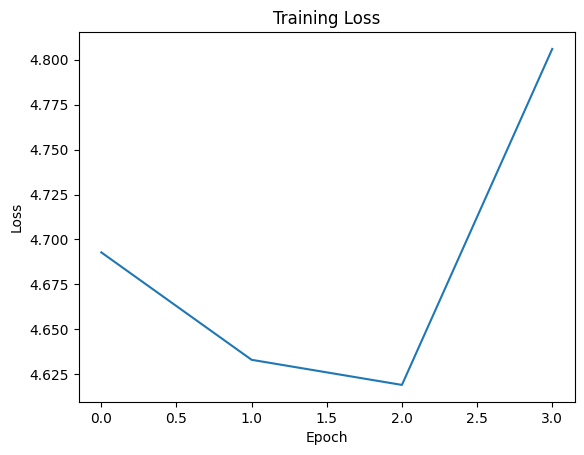

In [19]:
# Количество эпох
epochs = 5

# Список для хранения значений потерь на каждой эпохе
loss_values = []
best_loss = float('inf')
best_acc = 0.8

for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Используйте tqdm для отображения прогресса
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_data_loader)
    loss_values.append(avg_train_loss)

    print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    model.eval()
    predictions , true_labels = [], []

    for batch in tqdm(test_data_loader, desc=f"Validation Epoch {epoch+1}"):
        with torch.no_grad():
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            
            print(logits.shape)
            predictions.extend(np.argmax(logits, axis=1).flatten())
            true_labels.extend(label_ids.flatten())

    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"Accuracy: {acc:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

    # Ранняя остановка по потерям на валидации
    if avg_train_loss > best_loss:
        print("Early stopping due to increase in validation loss")
        break

    # Ранняя остановка по точности на валидации
    if acc >= best_acc:
        print("Early stopping due to reaching target accuracy")
        break

    best_loss = avg_train_loss

plot_loss(loss_values)

In [20]:
# plot_loss(loss_values)
